In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import nn
import numpy as np 
import matplotlib.pyplot as plt
import torchvision.models as models
import pathlib
import os
import tqdm
# import torchvision.transforms.InterpolationMode.BICUBIC
from PIL import Image

#topk from https://github.com/oval-group/smooth-topk
from topk.svm import SmoothTop1SVM, SmoothTopkSVM
from model import ValFolder

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
resnet18 = models.resnet18(pretrained=True)
resnet50 = models.resnet50(pretrained=True)

for param in resnet18.parameters():
    param.requires_grad = False

for param in resnet50.parameters():
    param.requires_grad = False


original_fc = resnet18.fc
new_lin = nn.Sequential(
    nn.Linear(original_fc.in_features, original_fc.in_features),
    nn.ReLU(),
    nn.Linear(original_fc.in_features, 200)
)

resnet18.fc = nn.Linear(resnet18.fc.in_features, 200)
# resnet18.fc = new_lin
resnet50.fc = nn.Linear(resnet50.fc.in_features, 200)
resnet18.avgpool = nn.AdaptiveAvgPool2d(1)
# resnet18.avgpool = nn.AdaptiveAvgPool2d(1)

In [4]:
data_dir = pathlib.Path('./data/tiny-imagenet-200')
image_count = len(list(data_dir.glob('**/*.JPEG')))
CLASS_NAMES = np.array([item.name for item in (data_dir / 'train').glob('*')])
print('Discovered {} images'.format(image_count))

Discovered 120000 images


In [5]:
# Create the training data generator
batch_size = 64

data_transforms = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
#     transforms.Normalize((0.4805, 0.4483, 0.3978), (0.2177, 0.2138, 0.2136)),
])

random_transformations = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(1),
    transforms.Resize((224, 224), interpolation=Image.BICUBIC), 
    transforms.ToTensor(),
#     transforms.Normalize((0.4805, 0.4483, 0.3978), (0.2177, 0.2138, 0.2136)),
])

# augment_transforms = transforms.Compose([
#     transforms.RandomHorizontalFlip(0.5),
#     transforms.RandomVerticalFlip(0.5),
#     transforms.RandomGrayscale(0.1),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
#     transforms.Pad(5, padding_mode='reflect'),
#     transforms.RandomRotation(15),
#     transforms.RandomPerspective(distortion_scale=0.3, p=0.3),
#     transforms.RandomCrop(64),
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
# ])


original = torchvision.datasets.ImageFolder(data_dir / 'train', data_transforms)
random_rot = torchvision.datasets.ImageFolder(data_dir / 'train', random_transformations)
# augmented_set = torchvision.datasets.ImageFolder(data_dir / 'train', augment_transforms)
train_sets = [original, random_rot] 

# train_set = torch.utils.data.ConcatDataset(train_sets)

train_set = torchvision.datasets.ImageFolder(data_dir / 'train', data_transforms)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                           shuffle=True, num_workers=4, pin_memory=True)
    

val_set = ValFolder(CLASS_NAMES, data_dir / 'val', data_transforms)
val_set.__getitem__(1)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                         shuffle=True, num_workers=4, pin_memory=True)

In [6]:
def combinedLoss():
    crossEntropy = nn.CrossEntropyLoss()
    top1 = SmoothTop1SVM(n_classes=200).cuda()
    def calculateLoss(output, target):
        return 10*top1(output, target) + crossEntropy(output, target)
    
    return calculateLoss

In [7]:
num_epochs = 10

# Create a simple model
model = resnet50
model.to(device)
optim = torch.optim.Adam(model.parameters())
# criterion = nn.CrossEntropyLoss()
# c = topk.SmoothTop1SVM(n_classes=200, k=1).cuda()

criterion = combinedLoss()

# optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
decay_rate = 0.9
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, decay_rate)


train_losses = []
val_losses = []

train_accuracy = []
val_accuracy = []

for i in range(num_epochs):
    model.train()
    train_total, train_correct = 0,0
    for idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optim.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        train_losses.append(loss.item())
        
        loss.backward()
        optim.step()
                
        _, predicted = outputs.max(1)
        train_total += targets.size(0)
        train_correct += predicted.eq(targets).sum().item()
        print(f'training {100 * idx / len(train_loader):.2f}%: {train_correct / train_total:.3f}. Loss: {loss.item()}')
    
    train_accuracy.append(train_correct/train_total)
    
    torch.save({
        'net': model.state_dict(),
    }, 'latest.pt')

    model.eval()
    with torch.no_grad():
        val_loss_epoch = 0
        val_total, val_correct = 0,0
        for idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss_epoch += loss.item()

            _, predicted = outputs.max(1)
            
            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()
            print(f'val {100 * idx / len(val_loader):.2f}%: {val_correct / val_total:.3f}. Loss: {loss.item()}')
    
    val_acc = val_correct/val_total
    if val_acc > max(val_accuracy, default=0):
        torch.save({
            'net': model.state_dict(),
        }, 'latest.pt')
    
    val_accuracy.append(val_correct/val_total)
    val_losses.append(val_loss_epoch / batch_size)
    
    my_lr_scheduler.step()

Setting tau to 1.0
training 0.00%: 0.000. Loss: 68.72651672363281
training 0.06%: 0.000. Loss: 73.12965393066406
training 0.13%: 0.010. Loss: 73.34344482421875
training 0.19%: 0.012. Loss: 77.77564239501953
training 0.26%: 0.009. Loss: 75.767333984375
training 0.32%: 0.010. Loss: 74.12443542480469
training 0.38%: 0.009. Loss: 74.89485168457031
training 0.45%: 0.018. Loss: 76.63504028320312
training 0.51%: 0.016. Loss: 75.69257354736328
training 0.58%: 0.014. Loss: 77.21463775634766
training 0.64%: 0.014. Loss: 74.13011932373047
training 0.70%: 0.014. Loss: 70.56387329101562
training 0.77%: 0.014. Loss: 74.0667495727539
training 0.83%: 0.013. Loss: 73.90067291259766
training 0.90%: 0.014. Loss: 69.53012084960938
training 0.96%: 0.015. Loss: 71.6358413696289
training 1.02%: 0.016. Loss: 69.47107696533203
training 1.09%: 0.015. Loss: 70.7853012084961
training 1.15%: 0.016. Loss: 68.75437927246094
training 1.22%: 0.019. Loss: 68.96110534667969
training 1.28%: 0.019. Loss: 69.0752944946289


training 11.13%: 0.247. Loss: 38.849365234375
training 11.20%: 0.249. Loss: 38.940433502197266
training 11.26%: 0.249. Loss: 41.11712646484375
training 11.32%: 0.250. Loss: 41.104026794433594
training 11.39%: 0.250. Loss: 44.32744216918945
training 11.45%: 0.251. Loss: 41.30336380004883
training 11.52%: 0.252. Loss: 40.72846984863281
training 11.58%: 0.253. Loss: 35.27003479003906
training 11.64%: 0.254. Loss: 39.981910705566406
training 11.71%: 0.254. Loss: 41.89144515991211
training 11.77%: 0.255. Loss: 40.23933410644531
training 11.84%: 0.256. Loss: 41.14213943481445
training 11.90%: 0.257. Loss: 41.931949615478516
training 11.96%: 0.258. Loss: 37.316810607910156
training 12.03%: 0.258. Loss: 38.968772888183594
training 12.09%: 0.259. Loss: 35.43988037109375
training 12.16%: 0.260. Loss: 39.85939025878906
training 12.22%: 0.260. Loss: 36.769256591796875
training 12.28%: 0.262. Loss: 35.460540771484375
training 12.35%: 0.263. Loss: 34.2700309753418
training 12.41%: 0.263. Loss: 40.63

training 22.01%: 0.349. Loss: 32.78778839111328
training 22.07%: 0.349. Loss: 30.360939025878906
training 22.14%: 0.350. Loss: 33.985267639160156
training 22.20%: 0.350. Loss: 29.824787139892578
training 22.26%: 0.351. Loss: 29.000436782836914
training 22.33%: 0.352. Loss: 27.8521785736084
training 22.39%: 0.352. Loss: 33.05509567260742
training 22.46%: 0.352. Loss: 35.575504302978516
training 22.52%: 0.353. Loss: 31.93438148498535
training 22.58%: 0.353. Loss: 32.84530258178711
training 22.65%: 0.354. Loss: 27.117984771728516
training 22.71%: 0.354. Loss: 29.047372817993164
training 22.78%: 0.354. Loss: 33.659976959228516
training 22.84%: 0.355. Loss: 29.903396606445312
training 22.90%: 0.355. Loss: 32.051856994628906
training 22.97%: 0.356. Loss: 29.23585319519043
training 23.03%: 0.356. Loss: 31.058298110961914
training 23.10%: 0.356. Loss: 29.483064651489258
training 23.16%: 0.357. Loss: 30.189865112304688
training 23.22%: 0.357. Loss: 31.85620880126953
training 23.29%: 0.358. Loss

training 32.89%: 0.402. Loss: 29.396207809448242
training 32.95%: 0.402. Loss: 30.605838775634766
training 33.01%: 0.403. Loss: 31.556825637817383
training 33.08%: 0.403. Loss: 31.188121795654297
training 33.14%: 0.403. Loss: 30.768774032592773
training 33.21%: 0.403. Loss: 30.623279571533203
training 33.27%: 0.403. Loss: 25.685461044311523
training 33.33%: 0.403. Loss: 29.74124526977539
training 33.40%: 0.404. Loss: 28.102264404296875
training 33.46%: 0.404. Loss: 32.430912017822266
training 33.53%: 0.404. Loss: 28.298124313354492
training 33.59%: 0.404. Loss: 29.991151809692383
training 33.65%: 0.405. Loss: 23.10209846496582
training 33.72%: 0.405. Loss: 27.622669219970703
training 33.78%: 0.405. Loss: 27.478944778442383
training 33.85%: 0.405. Loss: 33.8886604309082
training 33.91%: 0.406. Loss: 27.040510177612305
training 33.97%: 0.406. Loss: 30.641782760620117
training 34.04%: 0.406. Loss: 29.98995018005371
training 34.10%: 0.406. Loss: 29.17790985107422
training 34.17%: 0.406. Lo

training 43.76%: 0.433. Loss: 27.062734603881836
training 43.83%: 0.434. Loss: 29.66847038269043
training 43.89%: 0.434. Loss: 24.718231201171875
training 43.95%: 0.434. Loss: 29.556583404541016
training 44.02%: 0.434. Loss: 29.44645118713379
training 44.08%: 0.434. Loss: 23.14316177368164
training 44.15%: 0.434. Loss: 24.887596130371094
training 44.21%: 0.435. Loss: 29.389387130737305
training 44.27%: 0.435. Loss: 28.088682174682617
training 44.34%: 0.435. Loss: 28.11955451965332
training 44.40%: 0.435. Loss: 24.971797943115234
training 44.47%: 0.435. Loss: 24.155731201171875
training 44.53%: 0.436. Loss: 21.208833694458008
training 44.59%: 0.436. Loss: 28.091655731201172
training 44.66%: 0.436. Loss: 28.54085350036621
training 44.72%: 0.436. Loss: 20.71910858154297
training 44.79%: 0.436. Loss: 24.664690017700195
training 44.85%: 0.436. Loss: 30.128084182739258
training 44.91%: 0.437. Loss: 26.17457389831543
training 44.98%: 0.437. Loss: 26.45725440979004
training 45.04%: 0.437. Loss

training 54.64%: 0.454. Loss: 26.98491096496582
training 54.70%: 0.454. Loss: 26.514232635498047
training 54.77%: 0.454. Loss: 27.153865814208984
training 54.83%: 0.454. Loss: 30.358867645263672
training 54.89%: 0.454. Loss: 24.010866165161133
training 54.96%: 0.454. Loss: 20.681915283203125
training 55.02%: 0.454. Loss: 26.74533462524414
training 55.09%: 0.455. Loss: 24.328907012939453
training 55.15%: 0.455. Loss: 20.54022216796875
training 55.21%: 0.455. Loss: 32.45476150512695
training 55.28%: 0.455. Loss: 23.149757385253906
training 55.34%: 0.455. Loss: 27.614948272705078
training 55.41%: 0.455. Loss: 23.254337310791016
training 55.47%: 0.455. Loss: 36.162841796875
training 55.53%: 0.455. Loss: 27.521495819091797
training 55.60%: 0.455. Loss: 32.77549362182617
training 55.66%: 0.455. Loss: 27.569303512573242
training 55.73%: 0.456. Loss: 24.138259887695312
training 55.79%: 0.456. Loss: 25.654659271240234
training 55.85%: 0.456. Loss: 28.635494232177734
training 55.92%: 0.456. Loss

training 65.52%: 0.469. Loss: 26.091964721679688
training 65.58%: 0.469. Loss: 27.787912368774414
training 65.64%: 0.469. Loss: 26.666004180908203
training 65.71%: 0.469. Loss: 26.42233657836914
training 65.77%: 0.469. Loss: 22.89659881591797
training 65.83%: 0.469. Loss: 30.851408004760742
training 65.90%: 0.469. Loss: 29.428070068359375
training 65.96%: 0.469. Loss: 28.112747192382812
training 66.03%: 0.469. Loss: 28.003101348876953
training 66.09%: 0.469. Loss: 30.728370666503906
training 66.15%: 0.469. Loss: 27.327720642089844
training 66.22%: 0.469. Loss: 30.856035232543945
training 66.28%: 0.469. Loss: 28.883920669555664
training 66.35%: 0.469. Loss: 31.042951583862305
training 66.41%: 0.469. Loss: 25.982547760009766
training 66.47%: 0.470. Loss: 24.592300415039062
training 66.54%: 0.470. Loss: 20.6320858001709
training 66.60%: 0.470. Loss: 25.587486267089844
training 66.67%: 0.470. Loss: 23.98851203918457
training 66.73%: 0.470. Loss: 25.727092742919922
training 66.79%: 0.470. L

training 76.39%: 0.480. Loss: 22.314992904663086
training 76.46%: 0.480. Loss: 29.699275970458984
training 76.52%: 0.480. Loss: 27.309175491333008
training 76.58%: 0.480. Loss: 25.46297264099121
training 76.65%: 0.480. Loss: 33.99073791503906
training 76.71%: 0.480. Loss: 19.729305267333984
training 76.78%: 0.480. Loss: 20.53410530090332
training 76.84%: 0.481. Loss: 20.125194549560547
training 76.90%: 0.481. Loss: 25.551687240600586
training 76.97%: 0.481. Loss: 32.08468246459961
training 77.03%: 0.480. Loss: 34.694889068603516
training 77.10%: 0.481. Loss: 22.561050415039062
training 77.16%: 0.481. Loss: 22.953022003173828
training 77.22%: 0.481. Loss: 29.83565902709961
training 77.29%: 0.481. Loss: 28.570158004760742
training 77.35%: 0.481. Loss: 22.075729370117188
training 77.42%: 0.481. Loss: 22.381933212280273
training 77.48%: 0.481. Loss: 26.37773323059082
training 77.54%: 0.481. Loss: 25.555416107177734
training 77.61%: 0.481. Loss: 27.063730239868164
training 77.67%: 0.481. Lo

training 87.27%: 0.490. Loss: 35.67768096923828
training 87.33%: 0.490. Loss: 16.7315616607666
training 87.40%: 0.490. Loss: 27.01946258544922
training 87.46%: 0.490. Loss: 26.099071502685547
training 87.52%: 0.490. Loss: 24.771488189697266
training 87.59%: 0.490. Loss: 22.485233306884766
training 87.65%: 0.490. Loss: 28.94983673095703
training 87.72%: 0.491. Loss: 20.401212692260742
training 87.78%: 0.491. Loss: 26.049684524536133
training 87.84%: 0.491. Loss: 27.6977481842041
training 87.91%: 0.491. Loss: 22.74083137512207
training 87.97%: 0.491. Loss: 22.344139099121094
training 88.04%: 0.491. Loss: 22.355316162109375
training 88.10%: 0.491. Loss: 26.260515213012695
training 88.16%: 0.491. Loss: 29.514083862304688
training 88.23%: 0.491. Loss: 27.743667602539062
training 88.29%: 0.491. Loss: 22.693340301513672
training 88.36%: 0.491. Loss: 22.549667358398438
training 88.42%: 0.491. Loss: 25.570701599121094
training 88.48%: 0.491. Loss: 23.292436599731445
training 88.55%: 0.491. Loss

training 98.14%: 0.499. Loss: 26.882720947265625
training 98.21%: 0.499. Loss: 24.156158447265625
training 98.27%: 0.499. Loss: 29.827089309692383
training 98.34%: 0.499. Loss: 25.29083251953125
training 98.40%: 0.499. Loss: 23.259063720703125
training 98.46%: 0.499. Loss: 24.579208374023438
training 98.53%: 0.499. Loss: 23.36224937438965
training 98.59%: 0.499. Loss: 24.499298095703125
training 98.66%: 0.499. Loss: 20.409149169921875
training 98.72%: 0.499. Loss: 28.584068298339844
training 98.78%: 0.499. Loss: 30.787527084350586
training 98.85%: 0.499. Loss: 24.564367294311523
training 98.91%: 0.499. Loss: 24.723735809326172
training 98.98%: 0.499. Loss: 18.256677627563477
training 99.04%: 0.499. Loss: 27.71506118774414
training 99.10%: 0.499. Loss: 31.276290893554688
training 99.17%: 0.499. Loss: 17.897748947143555
training 99.23%: 0.499. Loss: 21.881031036376953
training 99.30%: 0.499. Loss: 30.165916442871094
training 99.36%: 0.499. Loss: 28.77789306640625
training 99.42%: 0.500. 

val 99.36%: 0.571. Loss: 20.129009246826172
training 0.00%: 0.547. Loss: 25.027599334716797
training 0.06%: 0.523. Loss: 28.840364456176758
training 0.13%: 0.490. Loss: 30.723295211791992
training 0.19%: 0.520. Loss: 23.653261184692383
training 0.26%: 0.541. Loss: 21.03400230407715
training 0.32%: 0.539. Loss: 25.850505828857422
training 0.38%: 0.551. Loss: 18.93747329711914
training 0.45%: 0.551. Loss: 25.036914825439453
training 0.51%: 0.557. Loss: 25.402189254760742
training 0.58%: 0.566. Loss: 23.128511428833008
training 0.64%: 0.577. Loss: 19.169282913208008
training 0.70%: 0.576. Loss: 27.150325775146484
training 0.77%: 0.583. Loss: 19.906883239746094
training 0.83%: 0.579. Loss: 23.57293701171875
training 0.90%: 0.580. Loss: 21.847204208374023
training 0.96%: 0.589. Loss: 16.852649688720703
training 1.02%: 0.591. Loss: 22.125755310058594
training 1.09%: 0.595. Loss: 21.242626190185547
training 1.15%: 0.597. Loss: 22.182201385498047
training 1.22%: 0.595. Loss: 21.54043197631836


training 11.00%: 0.604. Loss: 22.71027183532715
training 11.07%: 0.604. Loss: 18.834260940551758
training 11.13%: 0.604. Loss: 26.13343620300293
training 11.20%: 0.605. Loss: 18.46748161315918
training 11.26%: 0.604. Loss: 26.907617568969727
training 11.32%: 0.603. Loss: 25.943986892700195
training 11.39%: 0.604. Loss: 21.26262092590332
training 11.45%: 0.604. Loss: 24.47010040283203
training 11.52%: 0.604. Loss: 24.16246795654297
training 11.58%: 0.604. Loss: 19.686925888061523
training 11.64%: 0.603. Loss: 26.125110626220703
training 11.71%: 0.604. Loss: 17.349449157714844
training 11.77%: 0.604. Loss: 22.358509063720703
training 11.84%: 0.604. Loss: 20.149255752563477
training 11.90%: 0.604. Loss: 21.734663009643555
training 11.96%: 0.604. Loss: 24.531112670898438
training 12.03%: 0.604. Loss: 24.768901824951172
training 12.09%: 0.604. Loss: 21.26825714111328
training 12.16%: 0.604. Loss: 21.60085105895996
training 12.22%: 0.604. Loss: 20.610214233398438
training 12.28%: 0.605. Loss

training 21.88%: 0.602. Loss: 15.906298637390137
training 21.94%: 0.602. Loss: 27.49713134765625
training 22.01%: 0.602. Loss: 21.040124893188477
training 22.07%: 0.602. Loss: 25.079755783081055
training 22.14%: 0.602. Loss: 27.50027084350586
training 22.20%: 0.602. Loss: 17.532011032104492
training 22.26%: 0.602. Loss: 24.977176666259766
training 22.33%: 0.602. Loss: 24.691776275634766
training 22.39%: 0.601. Loss: 29.403461456298828
training 22.46%: 0.601. Loss: 23.8441162109375
training 22.52%: 0.601. Loss: 27.12165641784668
training 22.58%: 0.601. Loss: 22.721622467041016
training 22.65%: 0.601. Loss: 26.742631912231445
training 22.71%: 0.601. Loss: 20.300556182861328
training 22.78%: 0.601. Loss: 28.125818252563477
training 22.84%: 0.601. Loss: 25.42132568359375
training 22.90%: 0.601. Loss: 23.93498992919922
training 22.97%: 0.601. Loss: 23.770606994628906
training 23.03%: 0.601. Loss: 24.16582679748535
training 23.10%: 0.601. Loss: 20.79924964904785
training 23.16%: 0.601. Loss:

training 32.76%: 0.603. Loss: 25.97947883605957
training 32.82%: 0.603. Loss: 23.063356399536133
training 32.89%: 0.603. Loss: 23.63865852355957
training 32.95%: 0.603. Loss: 19.722806930541992
training 33.01%: 0.603. Loss: 24.37906837463379
training 33.08%: 0.603. Loss: 23.63187599182129
training 33.14%: 0.603. Loss: 25.731319427490234
training 33.21%: 0.603. Loss: 24.17945671081543
training 33.27%: 0.603. Loss: 26.893110275268555
training 33.33%: 0.603. Loss: 21.72810935974121
training 33.40%: 0.603. Loss: 30.79889678955078
training 33.46%: 0.603. Loss: 22.46405792236328
training 33.53%: 0.603. Loss: 24.445125579833984
training 33.59%: 0.603. Loss: 27.571393966674805
training 33.65%: 0.603. Loss: 22.48055648803711
training 33.72%: 0.602. Loss: 24.03114891052246
training 33.78%: 0.603. Loss: 20.630821228027344
training 33.85%: 0.603. Loss: 22.696796417236328
training 33.91%: 0.603. Loss: 22.59081268310547
training 33.97%: 0.603. Loss: 23.289934158325195
training 34.04%: 0.603. Loss: 2

training 43.63%: 0.603. Loss: 23.24079704284668
training 43.70%: 0.603. Loss: 27.983646392822266
training 43.76%: 0.603. Loss: 29.698427200317383
training 43.83%: 0.603. Loss: 18.18517303466797
training 43.89%: 0.603. Loss: 21.722421646118164
training 43.95%: 0.603. Loss: 22.112781524658203
training 44.02%: 0.604. Loss: 18.472087860107422
training 44.08%: 0.603. Loss: 29.591876983642578
training 44.15%: 0.603. Loss: 24.40685272216797
training 44.21%: 0.603. Loss: 28.524497985839844
training 44.27%: 0.603. Loss: 21.95032501220703
training 44.34%: 0.603. Loss: 22.540424346923828
training 44.40%: 0.603. Loss: 25.44074058532715
training 44.47%: 0.603. Loss: 26.020002365112305
training 44.53%: 0.603. Loss: 26.61972999572754
training 44.59%: 0.603. Loss: 21.507495880126953
training 44.66%: 0.603. Loss: 31.83185386657715
training 44.72%: 0.603. Loss: 21.705341339111328
training 44.79%: 0.603. Loss: 26.359697341918945
training 44.85%: 0.603. Loss: 23.220388412475586
training 44.91%: 0.603. Los

training 54.51%: 0.602. Loss: 23.76618003845215
training 54.57%: 0.602. Loss: 26.11804962158203
training 54.64%: 0.602. Loss: 21.259748458862305
training 54.70%: 0.602. Loss: 32.16233825683594
training 54.77%: 0.602. Loss: 26.682594299316406
training 54.83%: 0.601. Loss: 30.156347274780273
training 54.89%: 0.601. Loss: 24.42783546447754
training 54.96%: 0.601. Loss: 23.968191146850586
training 55.02%: 0.601. Loss: 18.89540672302246
training 55.09%: 0.601. Loss: 21.004419326782227
training 55.15%: 0.601. Loss: 26.270416259765625
training 55.21%: 0.601. Loss: 20.565311431884766
training 55.28%: 0.601. Loss: 20.801118850708008
training 55.34%: 0.601. Loss: 20.780214309692383
training 55.41%: 0.601. Loss: 21.745407104492188
training 55.47%: 0.601. Loss: 24.471235275268555
training 55.53%: 0.601. Loss: 20.883188247680664
training 55.60%: 0.602. Loss: 21.800230026245117
training 55.66%: 0.602. Loss: 22.62813377380371
training 55.73%: 0.602. Loss: 21.4101505279541
training 55.79%: 0.601. Loss

training 65.39%: 0.602. Loss: 21.888837814331055
training 65.45%: 0.602. Loss: 24.308950424194336
training 65.52%: 0.602. Loss: 24.81233024597168
training 65.58%: 0.602. Loss: 26.10034942626953
training 65.64%: 0.602. Loss: 21.041404724121094
training 65.71%: 0.602. Loss: 21.951696395874023
training 65.77%: 0.602. Loss: 23.806447982788086
training 65.83%: 0.602. Loss: 22.075714111328125
training 65.90%: 0.601. Loss: 33.2028923034668
training 65.96%: 0.601. Loss: 24.03438377380371
training 66.03%: 0.601. Loss: 19.78360366821289
training 66.09%: 0.601. Loss: 27.469755172729492
training 66.15%: 0.601. Loss: 26.658700942993164
training 66.22%: 0.602. Loss: 20.045461654663086
training 66.28%: 0.601. Loss: 25.605348587036133
training 66.35%: 0.601. Loss: 19.092044830322266
training 66.41%: 0.602. Loss: 16.21929931640625
training 66.47%: 0.602. Loss: 24.59130859375
training 66.54%: 0.602. Loss: 21.476839065551758
training 66.60%: 0.601. Loss: 24.866085052490234
training 66.67%: 0.601. Loss: 2

training 76.26%: 0.600. Loss: 19.650882720947266
training 76.33%: 0.600. Loss: 16.17266845703125
training 76.39%: 0.600. Loss: 25.07682991027832
training 76.46%: 0.600. Loss: 19.290136337280273
training 76.52%: 0.600. Loss: 26.206159591674805
training 76.58%: 0.600. Loss: 23.26197052001953
training 76.65%: 0.600. Loss: 21.62069320678711
training 76.71%: 0.600. Loss: 24.623165130615234
training 76.78%: 0.600. Loss: 23.460041046142578
training 76.84%: 0.600. Loss: 27.09298324584961
training 76.90%: 0.600. Loss: 21.634862899780273
training 76.97%: 0.600. Loss: 20.843307495117188
training 77.03%: 0.600. Loss: 22.43166160583496
training 77.10%: 0.600. Loss: 24.529211044311523
training 77.16%: 0.600. Loss: 26.77545928955078
training 77.22%: 0.600. Loss: 20.8200626373291
training 77.29%: 0.600. Loss: 18.84404754638672
training 77.35%: 0.600. Loss: 26.421100616455078
training 77.42%: 0.600. Loss: 29.115339279174805
training 77.48%: 0.600. Loss: 21.839197158813477
training 77.54%: 0.600. Loss: 

training 87.14%: 0.599. Loss: 25.524694442749023
training 87.20%: 0.599. Loss: 25.659181594848633
training 87.27%: 0.599. Loss: 22.675159454345703
training 87.33%: 0.599. Loss: 20.896146774291992
training 87.40%: 0.599. Loss: 25.731403350830078
training 87.46%: 0.599. Loss: 26.191892623901367
training 87.52%: 0.599. Loss: 26.274904251098633
training 87.59%: 0.599. Loss: 25.418556213378906
training 87.65%: 0.599. Loss: 20.0252742767334
training 87.72%: 0.599. Loss: 25.118778228759766
training 87.78%: 0.599. Loss: 22.871734619140625
training 87.84%: 0.599. Loss: 24.8448486328125
training 87.91%: 0.599. Loss: 18.28845977783203
training 87.97%: 0.599. Loss: 26.739398956298828
training 88.04%: 0.599. Loss: 29.796154022216797
training 88.10%: 0.599. Loss: 20.463157653808594
training 88.16%: 0.599. Loss: 31.0220947265625
training 88.23%: 0.599. Loss: 36.496971130371094
training 88.29%: 0.599. Loss: 18.318180084228516
training 88.36%: 0.599. Loss: 22.770610809326172
training 88.42%: 0.599. Los

training 98.02%: 0.598. Loss: 22.95223045349121
training 98.08%: 0.598. Loss: 19.960947036743164
training 98.14%: 0.598. Loss: 22.1946964263916
training 98.21%: 0.598. Loss: 21.608427047729492
training 98.27%: 0.598. Loss: 24.17432975769043
training 98.34%: 0.598. Loss: 23.468111038208008
training 98.40%: 0.598. Loss: 28.377885818481445
training 98.46%: 0.598. Loss: 22.355453491210938
training 98.53%: 0.598. Loss: 24.389972686767578
training 98.59%: 0.598. Loss: 25.0919189453125
training 98.66%: 0.598. Loss: 27.647802352905273
training 98.72%: 0.598. Loss: 21.96513557434082
training 98.78%: 0.598. Loss: 19.61902618408203
training 98.85%: 0.598. Loss: 21.300748825073242
training 98.91%: 0.598. Loss: 26.054853439331055
training 98.98%: 0.598. Loss: 26.01255989074707
training 99.04%: 0.598. Loss: 27.888933181762695
training 99.10%: 0.598. Loss: 21.500341415405273
training 99.17%: 0.598. Loss: 19.545194625854492
training 99.23%: 0.598. Loss: 23.892772674560547
training 99.30%: 0.598. Loss:

val 98.73%: 0.589. Loss: 19.745807647705078
val 99.36%: 0.588. Loss: 25.989458084106445
training 0.00%: 0.625. Loss: 22.081682205200195
training 0.06%: 0.633. Loss: 20.293758392333984
training 0.13%: 0.635. Loss: 20.242101669311523
training 0.19%: 0.648. Loss: 16.447837829589844
training 0.26%: 0.659. Loss: 19.506216049194336
training 0.32%: 0.661. Loss: 16.204578399658203
training 0.38%: 0.654. Loss: 19.962387084960938
training 0.45%: 0.654. Loss: 20.84588050842285
training 0.51%: 0.642. Loss: 26.231809616088867
training 0.58%: 0.644. Loss: 21.349105834960938
training 0.64%: 0.639. Loss: 22.745807647705078
training 0.70%: 0.629. Loss: 22.69432258605957
training 0.77%: 0.630. Loss: 21.86798095703125
training 0.83%: 0.633. Loss: 19.372032165527344
training 0.90%: 0.640. Loss: 15.473644256591797
training 0.96%: 0.644. Loss: 19.58997917175293
training 1.02%: 0.635. Loss: 29.349042892456055
training 1.09%: 0.636. Loss: 19.20992088317871
training 1.15%: 0.641. Loss: 21.52000617980957
traini

training 11.00%: 0.639. Loss: 22.55514144897461
training 11.07%: 0.639. Loss: 20.898975372314453
training 11.13%: 0.640. Loss: 15.71408462524414
training 11.20%: 0.640. Loss: 24.49706268310547
training 11.26%: 0.640. Loss: 19.859418869018555
training 11.32%: 0.641. Loss: 15.22360610961914
training 11.39%: 0.641. Loss: 20.229238510131836
training 11.45%: 0.640. Loss: 26.486570358276367
training 11.52%: 0.640. Loss: 24.848365783691406
training 11.58%: 0.640. Loss: 20.80478858947754
training 11.64%: 0.640. Loss: 21.573837280273438
training 11.71%: 0.639. Loss: 22.734678268432617
training 11.77%: 0.640. Loss: 16.43817901611328
training 11.84%: 0.640. Loss: 20.244131088256836
training 11.90%: 0.639. Loss: 23.616662979125977
training 11.96%: 0.640. Loss: 17.333097457885742
training 12.03%: 0.639. Loss: 25.335834503173828
training 12.09%: 0.639. Loss: 25.688968658447266
training 12.16%: 0.639. Loss: 25.893850326538086
training 12.22%: 0.639. Loss: 23.530061721801758
training 12.28%: 0.638. Lo

training 21.88%: 0.630. Loss: 23.526058197021484
training 21.94%: 0.630. Loss: 17.879026412963867
training 22.01%: 0.630. Loss: 20.974700927734375
training 22.07%: 0.631. Loss: 20.188600540161133
training 22.14%: 0.630. Loss: 25.36009979248047
training 22.20%: 0.631. Loss: 18.903837203979492
training 22.26%: 0.631. Loss: 23.043798446655273
training 22.33%: 0.631. Loss: 16.79712677001953
training 22.39%: 0.631. Loss: 22.20551300048828
training 22.46%: 0.630. Loss: 28.940284729003906
training 22.52%: 0.630. Loss: 18.874370574951172
training 22.58%: 0.631. Loss: 17.9240779876709
training 22.65%: 0.631. Loss: 15.31279182434082
training 22.71%: 0.631. Loss: 17.363801956176758
training 22.78%: 0.631. Loss: 19.760358810424805
training 22.84%: 0.631. Loss: 17.542678833007812
training 22.90%: 0.631. Loss: 24.006139755249023
training 22.97%: 0.631. Loss: 24.088708877563477
training 23.03%: 0.631. Loss: 22.173198699951172
training 23.10%: 0.631. Loss: 23.049945831298828
training 23.16%: 0.631. Lo

training 32.76%: 0.631. Loss: 20.193937301635742
training 32.82%: 0.631. Loss: 22.488637924194336
training 32.89%: 0.631. Loss: 20.331172943115234
training 32.95%: 0.631. Loss: 22.187400817871094
training 33.01%: 0.631. Loss: 18.305126190185547
training 33.08%: 0.631. Loss: 26.000728607177734
training 33.14%: 0.631. Loss: 22.87159538269043
training 33.21%: 0.631. Loss: 26.757375717163086
training 33.27%: 0.631. Loss: 17.359094619750977
training 33.33%: 0.631. Loss: 22.288679122924805
training 33.40%: 0.631. Loss: 25.583999633789062
training 33.46%: 0.631. Loss: 19.829803466796875
training 33.53%: 0.631. Loss: 20.487627029418945
training 33.59%: 0.631. Loss: 15.504380226135254
training 33.65%: 0.631. Loss: 25.681625366210938
training 33.72%: 0.631. Loss: 16.265867233276367
training 33.78%: 0.631. Loss: 19.45229721069336
training 33.85%: 0.631. Loss: 22.282562255859375
training 33.91%: 0.631. Loss: 19.77022933959961
training 33.97%: 0.631. Loss: 19.16069221496582
training 34.04%: 0.631. 

training 43.63%: 0.629. Loss: 24.59245491027832
training 43.70%: 0.629. Loss: 18.13434600830078
training 43.76%: 0.629. Loss: 21.869823455810547
training 43.83%: 0.629. Loss: 21.540565490722656
training 43.89%: 0.629. Loss: 24.809900283813477
training 43.95%: 0.629. Loss: 25.868492126464844
training 44.02%: 0.629. Loss: 25.587305068969727
training 44.08%: 0.629. Loss: 18.146013259887695
training 44.15%: 0.629. Loss: 21.503015518188477
training 44.21%: 0.629. Loss: 25.273088455200195
training 44.27%: 0.629. Loss: 16.749664306640625
training 44.34%: 0.629. Loss: 20.10539436340332
training 44.40%: 0.629. Loss: 21.51457977294922
training 44.47%: 0.629. Loss: 25.108238220214844
training 44.53%: 0.629. Loss: 25.63738441467285
training 44.59%: 0.629. Loss: 19.353946685791016
training 44.66%: 0.629. Loss: 20.19402503967285
training 44.72%: 0.629. Loss: 28.694210052490234
training 44.79%: 0.629. Loss: 20.959484100341797
training 44.85%: 0.629. Loss: 20.582996368408203
training 44.91%: 0.629. Lo

training 54.51%: 0.628. Loss: 22.89600372314453
training 54.57%: 0.628. Loss: 23.78687858581543
training 54.64%: 0.628. Loss: 17.74526596069336
training 54.70%: 0.628. Loss: 17.42706298828125
training 54.77%: 0.628. Loss: 25.069072723388672
training 54.83%: 0.628. Loss: 23.501808166503906
training 54.89%: 0.628. Loss: 17.877586364746094
training 54.96%: 0.628. Loss: 24.88872718811035
training 55.02%: 0.628. Loss: 21.470794677734375
training 55.09%: 0.628. Loss: 19.735898971557617
training 55.15%: 0.628. Loss: 19.636459350585938
training 55.21%: 0.628. Loss: 19.864303588867188
training 55.28%: 0.628. Loss: 23.648681640625
training 55.34%: 0.628. Loss: 22.35838508605957
training 55.41%: 0.628. Loss: 26.851621627807617
training 55.47%: 0.627. Loss: 24.59225845336914
training 55.53%: 0.627. Loss: 24.612289428710938
training 55.60%: 0.627. Loss: 20.87537384033203
training 55.66%: 0.627. Loss: 26.10659408569336
training 55.73%: 0.627. Loss: 19.64215087890625
training 55.79%: 0.627. Loss: 19.

training 65.39%: 0.626. Loss: 22.52939796447754
training 65.45%: 0.626. Loss: 15.905000686645508
training 65.52%: 0.626. Loss: 24.737607955932617
training 65.58%: 0.626. Loss: 21.82806968688965
training 65.64%: 0.626. Loss: 18.665908813476562
training 65.71%: 0.626. Loss: 18.505619049072266
training 65.77%: 0.626. Loss: 23.221059799194336
training 65.83%: 0.626. Loss: 18.2933406829834
training 65.90%: 0.626. Loss: 20.785049438476562
training 65.96%: 0.626. Loss: 29.484081268310547
training 66.03%: 0.626. Loss: 23.947664260864258
training 66.09%: 0.626. Loss: 21.871503829956055
training 66.15%: 0.626. Loss: 20.552898406982422
training 66.22%: 0.626. Loss: 20.339658737182617
training 66.28%: 0.626. Loss: 24.648616790771484
training 66.35%: 0.626. Loss: 23.746971130371094
training 66.41%: 0.626. Loss: 23.03766632080078
training 66.47%: 0.626. Loss: 24.5039119720459
training 66.54%: 0.626. Loss: 20.403854370117188
training 66.60%: 0.626. Loss: 25.119157791137695
training 66.67%: 0.626. Los

training 76.26%: 0.625. Loss: 20.67035484313965
training 76.33%: 0.625. Loss: 17.02128791809082
training 76.39%: 0.625. Loss: 19.162761688232422
training 76.46%: 0.625. Loss: 16.194801330566406
training 76.52%: 0.625. Loss: 25.16456413269043
training 76.58%: 0.625. Loss: 23.19690704345703
training 76.65%: 0.625. Loss: 21.151504516601562
training 76.71%: 0.625. Loss: 22.05283546447754
training 76.78%: 0.625. Loss: 25.14295196533203
training 76.84%: 0.625. Loss: 20.211837768554688
training 76.90%: 0.625. Loss: 19.582773208618164
training 76.97%: 0.625. Loss: 24.52065658569336
training 77.03%: 0.625. Loss: 23.626224517822266
training 77.10%: 0.625. Loss: 21.22834014892578
training 77.16%: 0.625. Loss: 20.988849639892578
training 77.22%: 0.625. Loss: 22.133928298950195
training 77.29%: 0.625. Loss: 27.417484283447266
training 77.35%: 0.625. Loss: 26.413925170898438
training 77.42%: 0.625. Loss: 21.315893173217773
training 77.48%: 0.625. Loss: 25.67021369934082
training 77.54%: 0.625. Loss:

training 87.14%: 0.624. Loss: 23.87005043029785
training 87.20%: 0.624. Loss: 20.6402645111084
training 87.27%: 0.624. Loss: 29.22280502319336
training 87.33%: 0.624. Loss: 25.755126953125
training 87.40%: 0.624. Loss: 21.630367279052734
training 87.46%: 0.624. Loss: 18.081571578979492
training 87.52%: 0.624. Loss: 27.35660743713379
training 87.59%: 0.624. Loss: 18.856033325195312
training 87.65%: 0.624. Loss: 17.59686279296875
training 87.72%: 0.624. Loss: 19.545072555541992
training 87.78%: 0.624. Loss: 26.053417205810547
training 87.84%: 0.624. Loss: 23.22775650024414
training 87.91%: 0.624. Loss: 24.73102569580078
training 87.97%: 0.624. Loss: 17.607467651367188
training 88.04%: 0.624. Loss: 24.28324317932129
training 88.10%: 0.624. Loss: 23.1418514251709
training 88.16%: 0.624. Loss: 17.79085350036621
training 88.23%: 0.624. Loss: 22.471132278442383
training 88.29%: 0.624. Loss: 22.75128173828125
training 88.36%: 0.624. Loss: 25.984127044677734
training 88.42%: 0.624. Loss: 24.135

training 98.02%: 0.623. Loss: 23.785282135009766
training 98.08%: 0.623. Loss: 23.50092315673828
training 98.14%: 0.623. Loss: 21.127410888671875
training 98.21%: 0.623. Loss: 23.4412784576416
training 98.27%: 0.623. Loss: 22.501827239990234
training 98.34%: 0.623. Loss: 22.20752716064453
training 98.40%: 0.623. Loss: 18.37265968322754
training 98.46%: 0.623. Loss: 30.353496551513672
training 98.53%: 0.623. Loss: 19.726036071777344
training 98.59%: 0.623. Loss: 25.548871994018555
training 98.66%: 0.623. Loss: 26.650442123413086
training 98.72%: 0.623. Loss: 20.672922134399414
training 98.78%: 0.623. Loss: 18.397939682006836
training 98.85%: 0.623. Loss: 24.462892532348633
training 98.91%: 0.623. Loss: 21.60957908630371
training 98.98%: 0.623. Loss: 18.522844314575195
training 99.04%: 0.623. Loss: 30.669578552246094
training 99.10%: 0.623. Loss: 23.2152156829834
training 99.17%: 0.623. Loss: 19.968015670776367
training 99.23%: 0.623. Loss: 20.473844528198242
training 99.30%: 0.623. Loss

training 0.00%: 0.656. Loss: 19.267223358154297
training 0.06%: 0.672. Loss: 18.341297149658203
training 0.13%: 0.630. Loss: 22.59210968017578
training 0.19%: 0.605. Loss: 21.281349182128906
training 0.26%: 0.616. Loss: 17.037961959838867
training 0.32%: 0.625. Loss: 18.887102127075195
training 0.38%: 0.634. Loss: 22.55251121520996
training 0.45%: 0.637. Loss: 20.48899269104004
training 0.51%: 0.642. Loss: 21.705604553222656
training 0.58%: 0.637. Loss: 24.939924240112305
training 0.64%: 0.636. Loss: 24.231645584106445
training 0.70%: 0.637. Loss: 20.277667999267578
training 0.77%: 0.637. Loss: 20.858095169067383
training 0.83%: 0.642. Loss: 17.699071884155273
training 0.90%: 0.639. Loss: 23.939186096191406
training 0.96%: 0.635. Loss: 21.47102165222168
training 1.02%: 0.638. Loss: 19.752548217773438
training 1.09%: 0.633. Loss: 27.379215240478516
training 1.15%: 0.636. Loss: 21.662866592407227
training 1.22%: 0.637. Loss: 18.898326873779297
training 1.28%: 0.637. Loss: 19.896595001220

training 11.00%: 0.649. Loss: 14.26098918914795
training 11.07%: 0.650. Loss: 17.140254974365234
training 11.13%: 0.650. Loss: 19.6094970703125
training 11.20%: 0.650. Loss: 22.245418548583984
training 11.26%: 0.651. Loss: 12.003365516662598
training 11.32%: 0.651. Loss: 16.47108268737793
training 11.39%: 0.651. Loss: 19.090700149536133
training 11.45%: 0.651. Loss: 22.042686462402344
training 11.52%: 0.651. Loss: 20.68072509765625
training 11.58%: 0.651. Loss: 19.02181053161621
training 11.64%: 0.651. Loss: 21.23008918762207
training 11.71%: 0.651. Loss: 15.46561050415039
training 11.77%: 0.652. Loss: 20.022735595703125
training 11.84%: 0.651. Loss: 24.38357162475586
training 11.90%: 0.651. Loss: 18.320640563964844
training 11.96%: 0.652. Loss: 15.864665031433105
training 12.03%: 0.652. Loss: 23.058454513549805
training 12.09%: 0.651. Loss: 24.960342407226562
training 12.16%: 0.651. Loss: 20.991966247558594
training 12.22%: 0.651. Loss: 18.48076820373535
training 12.28%: 0.651. Loss: 

training 21.88%: 0.650. Loss: 19.84055519104004
training 21.94%: 0.650. Loss: 20.758169174194336
training 22.01%: 0.650. Loss: 16.60703468322754
training 22.07%: 0.650. Loss: 21.152111053466797
training 22.14%: 0.650. Loss: 20.214353561401367
training 22.20%: 0.650. Loss: 25.81451416015625
training 22.26%: 0.650. Loss: 20.908416748046875
training 22.33%: 0.650. Loss: 23.77143669128418
training 22.39%: 0.650. Loss: 18.074432373046875
training 22.46%: 0.650. Loss: 22.13066864013672
training 22.52%: 0.649. Loss: 19.617162704467773
training 22.58%: 0.650. Loss: 19.054353713989258
training 22.65%: 0.649. Loss: 20.82958221435547
training 22.71%: 0.649. Loss: 19.418197631835938
training 22.78%: 0.649. Loss: 17.776195526123047
training 22.84%: 0.649. Loss: 22.222923278808594
training 22.90%: 0.649. Loss: 20.96567153930664
training 22.97%: 0.649. Loss: 19.228290557861328
training 23.03%: 0.649. Loss: 17.951234817504883
training 23.10%: 0.649. Loss: 19.911884307861328
training 23.16%: 0.649. Los

training 32.76%: 0.648. Loss: 24.6457462310791
training 32.82%: 0.648. Loss: 14.578256607055664
training 32.89%: 0.648. Loss: 21.03415298461914
training 32.95%: 0.648. Loss: 24.31670570373535
training 33.01%: 0.648. Loss: 20.335962295532227
training 33.08%: 0.648. Loss: 19.865427017211914
training 33.14%: 0.648. Loss: 24.61298179626465
training 33.21%: 0.648. Loss: 14.888996124267578
training 33.27%: 0.648. Loss: 18.983835220336914
training 33.33%: 0.648. Loss: 22.590192794799805
training 33.40%: 0.649. Loss: 18.25733757019043
training 33.46%: 0.648. Loss: 24.710180282592773
training 33.53%: 0.649. Loss: 18.794267654418945
training 33.59%: 0.648. Loss: 21.12188720703125
training 33.65%: 0.648. Loss: 22.375024795532227
training 33.72%: 0.648. Loss: 23.405498504638672
training 33.78%: 0.648. Loss: 21.12497329711914
training 33.85%: 0.648. Loss: 20.3026180267334
training 33.91%: 0.648. Loss: 22.99201774597168
training 33.97%: 0.648. Loss: 22.522804260253906
training 34.04%: 0.648. Loss: 1

training 43.63%: 0.647. Loss: 22.88030433654785
training 43.70%: 0.647. Loss: 21.363901138305664
training 43.76%: 0.647. Loss: 20.441410064697266
training 43.83%: 0.647. Loss: 18.042001724243164
training 43.89%: 0.647. Loss: 21.50098419189453
training 43.95%: 0.647. Loss: 21.86283302307129
training 44.02%: 0.647. Loss: 20.34352684020996
training 44.08%: 0.647. Loss: 15.541396141052246
training 44.15%: 0.647. Loss: 22.895309448242188
training 44.21%: 0.646. Loss: 25.574949264526367
training 44.27%: 0.646. Loss: 19.129108428955078
training 44.34%: 0.646. Loss: 17.970474243164062
training 44.40%: 0.646. Loss: 22.178796768188477
training 44.47%: 0.646. Loss: 17.423141479492188
training 44.53%: 0.647. Loss: 18.035993576049805
training 44.59%: 0.646. Loss: 24.81476402282715
training 44.66%: 0.646. Loss: 19.944456100463867
training 44.72%: 0.647. Loss: 18.137548446655273
training 44.79%: 0.646. Loss: 20.776277542114258
training 44.85%: 0.646. Loss: 20.459800720214844
training 44.91%: 0.646. L

training 54.51%: 0.643. Loss: 23.4095458984375
training 54.57%: 0.643. Loss: 19.790193557739258
training 54.64%: 0.643. Loss: 21.03981590270996
training 54.70%: 0.643. Loss: 22.307703018188477
training 54.77%: 0.643. Loss: 22.382774353027344
training 54.83%: 0.643. Loss: 21.071535110473633
training 54.89%: 0.643. Loss: 21.64516830444336
training 54.96%: 0.643. Loss: 19.864797592163086
training 55.02%: 0.643. Loss: 23.660938262939453
training 55.09%: 0.643. Loss: 19.455778121948242
training 55.15%: 0.643. Loss: 20.21400260925293
training 55.21%: 0.643. Loss: 18.29672622680664
training 55.28%: 0.643. Loss: 15.72594928741455
training 55.34%: 0.643. Loss: 16.799423217773438
training 55.41%: 0.643. Loss: 20.725997924804688
training 55.47%: 0.643. Loss: 18.935897827148438
training 55.53%: 0.643. Loss: 22.044330596923828
training 55.60%: 0.643. Loss: 22.831920623779297
training 55.66%: 0.643. Loss: 25.621919631958008
training 55.73%: 0.643. Loss: 19.814165115356445
training 55.79%: 0.643. Los

training 65.39%: 0.642. Loss: 20.424386978149414
training 65.45%: 0.642. Loss: 22.246475219726562
training 65.52%: 0.642. Loss: 18.630386352539062
training 65.58%: 0.642. Loss: 18.866443634033203
training 65.64%: 0.642. Loss: 23.4910831451416
training 65.71%: 0.642. Loss: 20.876379013061523
training 65.77%: 0.642. Loss: 20.635286331176758
training 65.83%: 0.642. Loss: 20.345523834228516
training 65.90%: 0.642. Loss: 16.756330490112305
training 65.96%: 0.642. Loss: 15.828577041625977
training 66.03%: 0.642. Loss: 15.319063186645508
training 66.09%: 0.642. Loss: 18.057483673095703
training 66.15%: 0.642. Loss: 24.846508026123047
training 66.22%: 0.642. Loss: 18.480670928955078
training 66.28%: 0.642. Loss: 19.82059097290039
training 66.35%: 0.642. Loss: 18.240760803222656
training 66.41%: 0.642. Loss: 22.5723819732666
training 66.47%: 0.642. Loss: 24.198280334472656
training 66.54%: 0.642. Loss: 20.965499877929688
training 66.60%: 0.642. Loss: 17.46033477783203
training 66.67%: 0.643. Lo

training 76.26%: 0.641. Loss: 21.027515411376953
training 76.33%: 0.641. Loss: 19.64501190185547
training 76.39%: 0.641. Loss: 20.336158752441406
training 76.46%: 0.641. Loss: 19.775510787963867
training 76.52%: 0.641. Loss: 20.905908584594727
training 76.58%: 0.641. Loss: 23.712236404418945
training 76.65%: 0.641. Loss: 28.854387283325195
training 76.71%: 0.641. Loss: 18.9802188873291
training 76.78%: 0.641. Loss: 22.424894332885742
training 76.84%: 0.641. Loss: 21.776256561279297
training 76.90%: 0.641. Loss: 30.56532859802246
training 76.97%: 0.641. Loss: 19.977901458740234
training 77.03%: 0.641. Loss: 17.14185333251953
training 77.10%: 0.641. Loss: 18.74177360534668
training 77.16%: 0.641. Loss: 21.479970932006836
training 77.22%: 0.641. Loss: 24.168088912963867
training 77.29%: 0.641. Loss: 24.103227615356445
training 77.35%: 0.641. Loss: 23.611621856689453
training 77.42%: 0.641. Loss: 25.48299789428711
training 77.48%: 0.641. Loss: 23.357154846191406
training 77.54%: 0.641. Los

training 87.14%: 0.641. Loss: 21.244829177856445
training 87.20%: 0.641. Loss: 26.567781448364258
training 87.27%: 0.641. Loss: 20.89280128479004
training 87.33%: 0.641. Loss: 19.5183048248291
training 87.40%: 0.641. Loss: 19.289987564086914
training 87.46%: 0.641. Loss: 19.84505271911621
training 87.52%: 0.641. Loss: 24.13175392150879
training 87.59%: 0.641. Loss: 21.01938247680664
training 87.65%: 0.641. Loss: 20.728601455688477
training 87.72%: 0.641. Loss: 23.246488571166992
training 87.78%: 0.641. Loss: 15.532962799072266
training 87.84%: 0.641. Loss: 19.480243682861328
training 87.91%: 0.641. Loss: 21.063249588012695
training 87.97%: 0.641. Loss: 21.40526580810547
training 88.04%: 0.641. Loss: 26.266963958740234
training 88.10%: 0.641. Loss: 21.98772621154785
training 88.16%: 0.641. Loss: 20.44943618774414
training 88.23%: 0.641. Loss: 27.664350509643555
training 88.29%: 0.641. Loss: 28.284513473510742
training 88.36%: 0.641. Loss: 26.919845581054688
training 88.42%: 0.640. Loss:

training 98.02%: 0.639. Loss: 23.060518264770508
training 98.08%: 0.639. Loss: 22.987564086914062
training 98.14%: 0.639. Loss: 26.543575286865234
training 98.21%: 0.639. Loss: 16.377992630004883
training 98.27%: 0.639. Loss: 14.419921875
training 98.34%: 0.639. Loss: 17.017677307128906
training 98.40%: 0.639. Loss: 18.81830596923828
training 98.46%: 0.639. Loss: 22.808551788330078
training 98.53%: 0.639. Loss: 18.835752487182617
training 98.59%: 0.639. Loss: 22.719736099243164
training 98.66%: 0.639. Loss: 22.36733055114746
training 98.72%: 0.639. Loss: 19.142147064208984
training 98.78%: 0.639. Loss: 17.772974014282227
training 98.85%: 0.640. Loss: 17.54363250732422
training 98.91%: 0.639. Loss: 23.524372100830078
training 98.98%: 0.640. Loss: 20.194862365722656
training 99.04%: 0.640. Loss: 15.48818588256836
training 99.10%: 0.640. Loss: 17.02041244506836
training 99.17%: 0.640. Loss: 21.278057098388672
training 99.23%: 0.640. Loss: 21.538490295410156
training 99.30%: 0.639. Loss: 2

val 98.09%: 0.602. Loss: 22.487892150878906
val 98.73%: 0.602. Loss: 24.011131286621094
val 99.36%: 0.602. Loss: 38.735347747802734
training 0.00%: 0.641. Loss: 15.842979431152344
training 0.06%: 0.656. Loss: 20.07678985595703
training 0.13%: 0.667. Loss: 19.53213119506836
training 0.19%: 0.676. Loss: 18.393192291259766
training 0.26%: 0.688. Loss: 18.8118896484375
training 0.32%: 0.664. Loss: 24.099529266357422
training 0.38%: 0.672. Loss: 19.67119598388672
training 0.45%: 0.670. Loss: 21.378847122192383
training 0.51%: 0.668. Loss: 18.196941375732422
training 0.58%: 0.661. Loss: 22.937301635742188
training 0.64%: 0.661. Loss: 18.32893180847168
training 0.70%: 0.667. Loss: 16.254127502441406
training 0.77%: 0.660. Loss: 24.345617294311523
training 0.83%: 0.662. Loss: 16.47235107421875
training 0.90%: 0.669. Loss: 15.872844696044922
training 0.96%: 0.670. Loss: 15.838968276977539
training 1.02%: 0.669. Loss: 21.92136001586914
training 1.09%: 0.673. Loss: 17.914676666259766
training 1.1

training 10.94%: 0.668. Loss: 17.854827880859375
training 11.00%: 0.668. Loss: 18.522289276123047
training 11.07%: 0.667. Loss: 20.61423683166504
training 11.13%: 0.667. Loss: 16.135093688964844
training 11.20%: 0.667. Loss: 21.541440963745117
training 11.26%: 0.667. Loss: 19.05828857421875
training 11.32%: 0.667. Loss: 17.91443634033203
training 11.39%: 0.668. Loss: 23.70065689086914
training 11.45%: 0.667. Loss: 26.825700759887695
training 11.52%: 0.667. Loss: 18.314777374267578
training 11.58%: 0.667. Loss: 24.4073486328125
training 11.64%: 0.667. Loss: 13.98344612121582
training 11.71%: 0.667. Loss: 19.62186622619629
training 11.77%: 0.667. Loss: 16.121662139892578
training 11.84%: 0.667. Loss: 25.503337860107422
training 11.90%: 0.666. Loss: 21.010190963745117
training 11.96%: 0.666. Loss: 19.12424659729004
training 12.03%: 0.667. Loss: 16.607341766357422
training 12.09%: 0.667. Loss: 19.584909439086914
training 12.16%: 0.666. Loss: 23.636703491210938
training 12.22%: 0.666. Loss:

training 21.82%: 0.663. Loss: 19.956642150878906
training 21.88%: 0.663. Loss: 19.497543334960938
training 21.94%: 0.663. Loss: 20.413389205932617
training 22.01%: 0.663. Loss: 18.683298110961914
training 22.07%: 0.663. Loss: 17.581871032714844
training 22.14%: 0.663. Loss: 17.002891540527344
training 22.20%: 0.663. Loss: 20.21560287475586
training 22.26%: 0.663. Loss: 19.603801727294922
training 22.33%: 0.663. Loss: 22.875381469726562
training 22.39%: 0.663. Loss: 22.42036247253418
training 22.46%: 0.663. Loss: 25.52149200439453
training 22.52%: 0.663. Loss: 18.841754913330078
training 22.58%: 0.663. Loss: 13.718706130981445
training 22.65%: 0.663. Loss: 21.332292556762695
training 22.71%: 0.662. Loss: 23.221689224243164
training 22.78%: 0.663. Loss: 15.284870147705078
training 22.84%: 0.662. Loss: 22.082399368286133
training 22.90%: 0.663. Loss: 19.749170303344727
training 22.97%: 0.663. Loss: 14.799800872802734
training 23.03%: 0.663. Loss: 20.547510147094727
training 23.10%: 0.662.

training 32.69%: 0.658. Loss: 18.70269012451172
training 32.76%: 0.658. Loss: 22.75709342956543
training 32.82%: 0.658. Loss: 16.61052703857422
training 32.89%: 0.658. Loss: 22.60491371154785
training 32.95%: 0.658. Loss: 21.389392852783203
training 33.01%: 0.658. Loss: 19.13985252380371
training 33.08%: 0.658. Loss: 22.97825813293457
training 33.14%: 0.658. Loss: 25.003215789794922
training 33.21%: 0.658. Loss: 23.952505111694336
training 33.27%: 0.658. Loss: 19.071352005004883
training 33.33%: 0.658. Loss: 18.049211502075195
training 33.40%: 0.658. Loss: 17.39470100402832
training 33.46%: 0.658. Loss: 20.963359832763672
training 33.53%: 0.658. Loss: 21.16004180908203
training 33.59%: 0.658. Loss: 19.504993438720703
training 33.65%: 0.658. Loss: 15.140024185180664
training 33.72%: 0.658. Loss: 13.609232902526855
training 33.78%: 0.658. Loss: 24.602060317993164
training 33.85%: 0.658. Loss: 16.28555679321289
training 33.91%: 0.658. Loss: 18.29160499572754
training 33.97%: 0.658. Loss: 

training 43.57%: 0.658. Loss: 19.874557495117188
training 43.63%: 0.658. Loss: 18.740755081176758
training 43.70%: 0.658. Loss: 20.676456451416016
training 43.76%: 0.658. Loss: 20.15719985961914
training 43.83%: 0.658. Loss: 24.6575927734375
training 43.89%: 0.658. Loss: 19.378679275512695
training 43.95%: 0.657. Loss: 26.967025756835938
training 44.02%: 0.657. Loss: 20.926179885864258
training 44.08%: 0.658. Loss: 21.513216018676758
training 44.15%: 0.657. Loss: 17.217575073242188
training 44.21%: 0.658. Loss: 21.83977508544922
training 44.27%: 0.658. Loss: 18.839584350585938
training 44.34%: 0.658. Loss: 15.931690216064453
training 44.40%: 0.658. Loss: 20.722564697265625
training 44.47%: 0.658. Loss: 17.36007308959961
training 44.53%: 0.658. Loss: 14.273201942443848
training 44.59%: 0.658. Loss: 20.782068252563477
training 44.66%: 0.658. Loss: 18.116168975830078
training 44.72%: 0.658. Loss: 21.64524269104004
training 44.79%: 0.658. Loss: 13.962248802185059
training 44.85%: 0.658. Lo

training 54.45%: 0.658. Loss: 26.324970245361328
training 54.51%: 0.658. Loss: 19.755443572998047
training 54.57%: 0.658. Loss: 16.178815841674805
training 54.64%: 0.658. Loss: 19.655275344848633
training 54.70%: 0.658. Loss: 22.94320297241211
training 54.77%: 0.658. Loss: 12.03467845916748
training 54.83%: 0.658. Loss: 30.72700309753418
training 54.89%: 0.658. Loss: 21.432044982910156
training 54.96%: 0.658. Loss: 20.49057388305664
training 55.02%: 0.659. Loss: 14.876192092895508
training 55.09%: 0.659. Loss: 17.96099853515625
training 55.15%: 0.659. Loss: 15.672477722167969
training 55.21%: 0.659. Loss: 19.849872589111328
training 55.28%: 0.659. Loss: 18.823875427246094
training 55.34%: 0.659. Loss: 19.97509765625
training 55.41%: 0.659. Loss: 20.106698989868164
training 55.47%: 0.659. Loss: 21.95163917541504
training 55.53%: 0.659. Loss: 22.85921859741211
training 55.60%: 0.659. Loss: 16.951398849487305
training 55.66%: 0.659. Loss: 20.39664077758789
training 55.73%: 0.659. Loss: 22

training 65.32%: 0.657. Loss: 21.501014709472656
training 65.39%: 0.657. Loss: 19.35810089111328
training 65.45%: 0.657. Loss: 18.84481430053711
training 65.52%: 0.657. Loss: 24.81846809387207
training 65.58%: 0.657. Loss: 18.26160430908203
training 65.64%: 0.657. Loss: 20.187543869018555
training 65.71%: 0.657. Loss: 23.672266006469727
training 65.77%: 0.657. Loss: 20.618167877197266
training 65.83%: 0.657. Loss: 22.3408260345459
training 65.90%: 0.656. Loss: 24.849546432495117
training 65.96%: 0.656. Loss: 22.3638973236084
training 66.03%: 0.657. Loss: 17.67220115661621
training 66.09%: 0.656. Loss: 25.925127029418945
training 66.15%: 0.656. Loss: 17.201507568359375
training 66.22%: 0.656. Loss: 20.09052848815918
training 66.28%: 0.656. Loss: 21.174707412719727
training 66.35%: 0.656. Loss: 20.15744972229004
training 66.41%: 0.656. Loss: 21.86823272705078
training 66.47%: 0.656. Loss: 19.135587692260742
training 66.54%: 0.656. Loss: 19.622114181518555
training 66.60%: 0.656. Loss: 21

training 76.14%: 0.656. Loss: 21.926620483398438
training 76.20%: 0.656. Loss: 21.102745056152344
training 76.26%: 0.656. Loss: 18.43674659729004
training 76.33%: 0.655. Loss: 23.95673942565918
training 76.39%: 0.655. Loss: 21.853946685791016
training 76.46%: 0.655. Loss: 19.915287017822266
training 76.52%: 0.656. Loss: 17.243749618530273
training 76.58%: 0.656. Loss: 21.329708099365234
training 76.65%: 0.656. Loss: 16.28815269470215
training 76.71%: 0.655. Loss: 24.71052360534668
training 76.78%: 0.655. Loss: 17.316158294677734
training 76.84%: 0.655. Loss: 19.032716751098633
training 76.90%: 0.655. Loss: 24.83070182800293
training 76.97%: 0.655. Loss: 17.630788803100586
training 77.03%: 0.655. Loss: 19.711212158203125
training 77.10%: 0.655. Loss: 20.111770629882812
training 77.16%: 0.655. Loss: 21.901996612548828
training 77.22%: 0.655. Loss: 13.930280685424805
training 77.29%: 0.655. Loss: 22.7500057220459
training 77.35%: 0.655. Loss: 25.603004455566406
training 77.42%: 0.655. Los

training 87.01%: 0.655. Loss: 23.152620315551758
training 87.08%: 0.655. Loss: 18.502962112426758
training 87.14%: 0.655. Loss: 26.173667907714844
training 87.20%: 0.655. Loss: 22.6191463470459
training 87.27%: 0.655. Loss: 17.397525787353516
training 87.33%: 0.655. Loss: 18.747777938842773
training 87.40%: 0.655. Loss: 21.781776428222656
training 87.46%: 0.655. Loss: 26.376861572265625
training 87.52%: 0.655. Loss: 21.09958839416504
training 87.59%: 0.655. Loss: 21.138416290283203
training 87.65%: 0.655. Loss: 24.020309448242188
training 87.72%: 0.655. Loss: 18.01983642578125
training 87.78%: 0.655. Loss: 21.244192123413086
training 87.84%: 0.655. Loss: 18.16243553161621
training 87.91%: 0.655. Loss: 14.967704772949219
training 87.97%: 0.655. Loss: 15.810853958129883
training 88.04%: 0.655. Loss: 22.830337524414062
training 88.10%: 0.655. Loss: 22.13279151916504
training 88.16%: 0.655. Loss: 18.681201934814453
training 88.23%: 0.655. Loss: 19.826696395874023
training 88.29%: 0.654. Lo

training 97.89%: 0.654. Loss: 27.208831787109375
training 97.95%: 0.654. Loss: 19.099620819091797
training 98.02%: 0.654. Loss: 21.51410484313965
training 98.08%: 0.654. Loss: 22.66841697692871
training 98.14%: 0.654. Loss: 19.85930061340332
training 98.21%: 0.654. Loss: 18.928871154785156
training 98.27%: 0.654. Loss: 18.253700256347656
training 98.34%: 0.654. Loss: 21.65669822692871
training 98.40%: 0.654. Loss: 18.1485595703125
training 98.46%: 0.654. Loss: 30.851152420043945
training 98.53%: 0.654. Loss: 23.181415557861328
training 98.59%: 0.654. Loss: 23.587093353271484
training 98.66%: 0.654. Loss: 19.755050659179688
training 98.72%: 0.654. Loss: 21.78464126586914
training 98.78%: 0.654. Loss: 21.108198165893555
training 98.85%: 0.654. Loss: 15.838360786437988
training 98.91%: 0.654. Loss: 16.536996841430664
training 98.98%: 0.654. Loss: 19.814123153686523
training 99.04%: 0.654. Loss: 22.56747817993164
training 99.10%: 0.654. Loss: 17.357646942138672
training 99.17%: 0.654. Loss

val 96.82%: 0.606. Loss: 16.44579315185547
val 97.45%: 0.606. Loss: 23.08657455444336
val 98.09%: 0.606. Loss: 20.082975387573242
val 98.73%: 0.606. Loss: 16.846036911010742
val 99.36%: 0.606. Loss: 16.262718200683594
training 0.00%: 0.672. Loss: 18.986425399780273
training 0.06%: 0.703. Loss: 15.329224586486816
training 0.13%: 0.693. Loss: 20.36876678466797
training 0.19%: 0.668. Loss: 20.653066635131836
training 0.26%: 0.653. Loss: 18.969572067260742
training 0.32%: 0.638. Loss: 21.527250289916992
training 0.38%: 0.643. Loss: 18.36324691772461
training 0.45%: 0.645. Loss: 21.571029663085938
training 0.51%: 0.641. Loss: 21.909709930419922
training 0.58%: 0.650. Loss: 17.773374557495117
training 0.64%: 0.634. Loss: 27.754764556884766
training 0.70%: 0.646. Loss: 14.066740989685059
training 0.77%: 0.659. Loss: 11.726038932800293
training 0.83%: 0.661. Loss: 17.836454391479492
training 0.90%: 0.651. Loss: 25.956466674804688
training 0.96%: 0.650. Loss: 21.396015167236328
training 1.02%: 

training 10.75%: 0.673. Loss: 16.018007278442383
training 10.81%: 0.673. Loss: 22.504249572753906
training 10.88%: 0.673. Loss: 16.966365814208984
training 10.94%: 0.673. Loss: 20.96114158630371
training 11.00%: 0.673. Loss: 19.977685928344727
training 11.07%: 0.673. Loss: 17.426462173461914
training 11.13%: 0.673. Loss: 18.848655700683594
training 11.20%: 0.673. Loss: 17.147579193115234
training 11.26%: 0.674. Loss: 17.58843421936035
training 11.32%: 0.674. Loss: 18.04481315612793
training 11.39%: 0.674. Loss: 14.453248977661133
training 11.45%: 0.674. Loss: 22.271108627319336
training 11.52%: 0.674. Loss: 15.74276065826416
training 11.58%: 0.674. Loss: 15.678736686706543
training 11.64%: 0.674. Loss: 18.641887664794922
training 11.71%: 0.674. Loss: 18.03060531616211
training 11.77%: 0.674. Loss: 17.62065887451172
training 11.84%: 0.674. Loss: 14.683588027954102
training 11.90%: 0.675. Loss: 19.042619705200195
training 11.96%: 0.675. Loss: 18.073986053466797
training 12.03%: 0.674. Lo

training 21.63%: 0.673. Loss: 19.925687789916992
training 21.69%: 0.673. Loss: 19.162580490112305
training 21.75%: 0.673. Loss: 18.46546745300293
training 21.82%: 0.673. Loss: 19.701141357421875
training 21.88%: 0.673. Loss: 16.823055267333984
training 21.94%: 0.673. Loss: 23.966419219970703
training 22.01%: 0.673. Loss: 23.110416412353516
training 22.07%: 0.672. Loss: 26.11856460571289
training 22.14%: 0.672. Loss: 15.166108131408691
training 22.20%: 0.672. Loss: 19.59306526184082
training 22.26%: 0.672. Loss: 29.81264305114746
training 22.33%: 0.672. Loss: 16.785022735595703
training 22.39%: 0.672. Loss: 21.57588005065918
training 22.46%: 0.672. Loss: 20.19137191772461
training 22.52%: 0.672. Loss: 17.295141220092773
training 22.58%: 0.672. Loss: 26.288646697998047
training 22.65%: 0.672. Loss: 18.676469802856445
training 22.71%: 0.672. Loss: 21.291536331176758
training 22.78%: 0.671. Loss: 20.86361312866211
training 22.84%: 0.672. Loss: 19.068042755126953
training 22.90%: 0.671. Los

training 32.50%: 0.668. Loss: 19.460817337036133
training 32.57%: 0.668. Loss: 20.83636474609375
training 32.63%: 0.668. Loss: 16.594242095947266
training 32.69%: 0.668. Loss: 15.054987907409668
training 32.76%: 0.668. Loss: 16.918134689331055
training 32.82%: 0.668. Loss: 19.271709442138672
training 32.89%: 0.668. Loss: 26.48478889465332
training 32.95%: 0.668. Loss: 16.02410888671875
training 33.01%: 0.668. Loss: 16.408838272094727
training 33.08%: 0.668. Loss: 23.548095703125
training 33.14%: 0.668. Loss: 22.183080673217773
training 33.21%: 0.668. Loss: 14.34287166595459
training 33.27%: 0.668. Loss: 23.80517578125
training 33.33%: 0.669. Loss: 17.305709838867188
training 33.40%: 0.669. Loss: 19.14753532409668
training 33.46%: 0.669. Loss: 16.940515518188477
training 33.53%: 0.669. Loss: 20.53414535522461
training 33.59%: 0.668. Loss: 22.22098731994629
training 33.65%: 0.668. Loss: 20.229938507080078
training 33.72%: 0.668. Loss: 19.603002548217773
training 33.78%: 0.668. Loss: 16.6

training 43.38%: 0.666. Loss: 16.539871215820312
training 43.44%: 0.666. Loss: 25.8784122467041
training 43.51%: 0.666. Loss: 19.392736434936523
training 43.57%: 0.666. Loss: 18.123987197875977
training 43.63%: 0.666. Loss: 17.446191787719727
training 43.70%: 0.666. Loss: 17.434232711791992
training 43.76%: 0.666. Loss: 15.324487686157227
training 43.83%: 0.666. Loss: 19.47406768798828
training 43.89%: 0.666. Loss: 15.178664207458496
training 43.95%: 0.666. Loss: 23.73093032836914
training 44.02%: 0.666. Loss: 17.393131256103516
training 44.08%: 0.666. Loss: 19.109375
training 44.15%: 0.666. Loss: 17.87474822998047
training 44.21%: 0.666. Loss: 19.60773468017578
training 44.27%: 0.666. Loss: 25.189481735229492
training 44.34%: 0.666. Loss: 16.668874740600586
training 44.40%: 0.666. Loss: 21.661495208740234
training 44.47%: 0.666. Loss: 19.36652374267578
training 44.53%: 0.666. Loss: 17.88987159729004
training 44.59%: 0.666. Loss: 18.699064254760742
training 44.66%: 0.666. Loss: 17.9234

training 54.25%: 0.667. Loss: 23.799955368041992
training 54.32%: 0.667. Loss: 26.42471694946289
training 54.38%: 0.667. Loss: 18.73882484436035
training 54.45%: 0.667. Loss: 18.692853927612305
training 54.51%: 0.667. Loss: 22.774795532226562
training 54.57%: 0.667. Loss: 20.068788528442383
training 54.64%: 0.667. Loss: 17.065292358398438
training 54.70%: 0.667. Loss: 21.943302154541016
training 54.77%: 0.667. Loss: 20.797901153564453
training 54.83%: 0.667. Loss: 21.540061950683594
training 54.89%: 0.667. Loss: 23.48825454711914
training 54.96%: 0.667. Loss: 17.253320693969727
training 55.02%: 0.667. Loss: 13.523672103881836
training 55.09%: 0.667. Loss: 15.219099044799805
training 55.15%: 0.667. Loss: 24.38775062561035
training 55.21%: 0.667. Loss: 19.512205123901367
training 55.28%: 0.667. Loss: 12.756553649902344
training 55.34%: 0.667. Loss: 14.603425025939941
training 55.41%: 0.667. Loss: 18.47614097595215
training 55.47%: 0.667. Loss: 16.75276756286621
training 55.53%: 0.667. Lo

training 65.13%: 0.666. Loss: 18.373489379882812
training 65.20%: 0.666. Loss: 22.77145767211914
training 65.26%: 0.666. Loss: 20.609012603759766
training 65.32%: 0.666. Loss: 12.74993896484375
training 65.39%: 0.666. Loss: 18.79083251953125
training 65.45%: 0.666. Loss: 21.5591983795166
training 65.52%: 0.666. Loss: 22.09867286682129
training 65.58%: 0.666. Loss: 19.540361404418945
training 65.64%: 0.666. Loss: 21.803611755371094
training 65.71%: 0.666. Loss: 17.995922088623047
training 65.77%: 0.666. Loss: 17.405153274536133
training 65.83%: 0.666. Loss: 16.34891128540039
training 65.90%: 0.666. Loss: 16.35568618774414
training 65.96%: 0.666. Loss: 18.393259048461914
training 66.03%: 0.666. Loss: 18.466793060302734
training 66.09%: 0.666. Loss: 18.737619400024414
training 66.15%: 0.666. Loss: 21.374671936035156
training 66.22%: 0.666. Loss: 20.677040100097656
training 66.28%: 0.666. Loss: 20.030668258666992
training 66.35%: 0.666. Loss: 23.610462188720703
training 66.41%: 0.666. Loss

training 76.01%: 0.664. Loss: 23.026641845703125
training 76.07%: 0.664. Loss: 22.4173526763916
training 76.14%: 0.664. Loss: 18.394258499145508
training 76.20%: 0.664. Loss: 21.46587562561035
training 76.26%: 0.664. Loss: 18.132936477661133
training 76.33%: 0.664. Loss: 26.456979751586914
training 76.39%: 0.664. Loss: 16.296371459960938
training 76.46%: 0.664. Loss: 19.518856048583984
training 76.52%: 0.664. Loss: 28.464401245117188
training 76.58%: 0.664. Loss: 24.997447967529297
training 76.65%: 0.664. Loss: 24.848283767700195
training 76.71%: 0.664. Loss: 21.21213150024414
training 76.78%: 0.664. Loss: 19.31807518005371
training 76.84%: 0.664. Loss: 18.371503829956055
training 76.90%: 0.664. Loss: 20.082439422607422
training 76.97%: 0.664. Loss: 20.245513916015625
training 77.03%: 0.664. Loss: 17.90595245361328
training 77.10%: 0.664. Loss: 18.853069305419922
training 77.16%: 0.664. Loss: 22.22859764099121
training 77.22%: 0.664. Loss: 22.031957626342773
training 77.29%: 0.664. Los

training 86.88%: 0.664. Loss: 17.88897705078125
training 86.95%: 0.664. Loss: 15.924243927001953
training 87.01%: 0.664. Loss: 17.819517135620117
training 87.08%: 0.664. Loss: 22.823814392089844
training 87.14%: 0.664. Loss: 21.01296615600586
training 87.20%: 0.664. Loss: 24.341663360595703
training 87.27%: 0.664. Loss: 20.087526321411133
training 87.33%: 0.664. Loss: 23.890958786010742
training 87.40%: 0.664. Loss: 25.982952117919922
training 87.46%: 0.664. Loss: 23.953628540039062
training 87.52%: 0.664. Loss: 20.822357177734375
training 87.59%: 0.664. Loss: 17.642629623413086
training 87.65%: 0.664. Loss: 22.68091583251953
training 87.72%: 0.664. Loss: 19.627365112304688
training 87.78%: 0.664. Loss: 19.69092559814453
training 87.84%: 0.664. Loss: 13.820148468017578
training 87.91%: 0.664. Loss: 19.949493408203125
training 87.97%: 0.664. Loss: 16.56080436706543
training 88.04%: 0.664. Loss: 11.11471939086914
training 88.10%: 0.664. Loss: 15.173395156860352
training 88.16%: 0.664. Lo

training 97.76%: 0.663. Loss: 19.229825973510742
training 97.82%: 0.663. Loss: 14.397444725036621
training 97.89%: 0.663. Loss: 20.314889907836914
training 97.95%: 0.663. Loss: 18.547216415405273
training 98.02%: 0.663. Loss: 15.44613265991211
training 98.08%: 0.663. Loss: 19.705278396606445
training 98.14%: 0.663. Loss: 21.596721649169922
training 98.21%: 0.663. Loss: 13.467044830322266
training 98.27%: 0.663. Loss: 18.46074867248535
training 98.34%: 0.663. Loss: 18.93451499938965
training 98.40%: 0.663. Loss: 13.186115264892578
training 98.46%: 0.663. Loss: 18.738027572631836
training 98.53%: 0.663. Loss: 20.6712703704834
training 98.59%: 0.663. Loss: 18.348194122314453
training 98.66%: 0.663. Loss: 18.465219497680664
training 98.72%: 0.663. Loss: 21.57474136352539
training 98.78%: 0.663. Loss: 17.565526962280273
training 98.85%: 0.663. Loss: 18.611801147460938
training 98.91%: 0.663. Loss: 21.835573196411133
training 98.98%: 0.663. Loss: 17.8433895111084
training 99.04%: 0.663. Loss

val 96.18%: 0.601. Loss: 21.798194885253906
val 96.82%: 0.602. Loss: 21.0712833404541
val 97.45%: 0.602. Loss: 24.7907657623291
val 98.09%: 0.602. Loss: 23.25120735168457
val 98.73%: 0.601. Loss: 23.665510177612305
val 99.36%: 0.602. Loss: 23.531970977783203
training 0.00%: 0.688. Loss: 21.26052474975586
training 0.06%: 0.633. Loss: 24.65127944946289
training 0.13%: 0.672. Loss: 13.705558776855469
training 0.19%: 0.668. Loss: 22.633920669555664
training 0.26%: 0.656. Loss: 22.523426055908203
training 0.32%: 0.656. Loss: 22.695777893066406
training 0.38%: 0.672. Loss: 12.336715698242188
training 0.45%: 0.672. Loss: 19.305706024169922
training 0.51%: 0.663. Loss: 19.009727478027344
training 0.58%: 0.667. Loss: 18.077392578125
training 0.64%: 0.662. Loss: 23.894466400146484
training 0.70%: 0.655. Loss: 23.326171875
training 0.77%: 0.647. Loss: 25.528705596923828
training 0.83%: 0.647. Loss: 25.60757827758789
training 0.90%: 0.648. Loss: 20.714677810668945
training 0.96%: 0.651. Loss: 19.9

training 10.75%: 0.678. Loss: 20.77119255065918
training 10.81%: 0.678. Loss: 12.519377708435059
training 10.88%: 0.679. Loss: 15.539403915405273
training 10.94%: 0.678. Loss: 19.221620559692383
training 11.00%: 0.679. Loss: 19.30498504638672
training 11.07%: 0.679. Loss: 17.53110694885254
training 11.13%: 0.679. Loss: 16.849899291992188
training 11.20%: 0.680. Loss: 15.853121757507324
training 11.26%: 0.680. Loss: 18.152088165283203
training 11.32%: 0.680. Loss: 15.211681365966797
training 11.39%: 0.680. Loss: 20.913471221923828
training 11.45%: 0.680. Loss: 15.710273742675781
training 11.52%: 0.680. Loss: 15.483017921447754
training 11.58%: 0.681. Loss: 16.666412353515625
training 11.64%: 0.681. Loss: 21.994789123535156
training 11.71%: 0.681. Loss: 18.105499267578125
training 11.77%: 0.681. Loss: 15.575058937072754
training 11.84%: 0.682. Loss: 16.953857421875
training 11.90%: 0.682. Loss: 19.958698272705078
training 11.96%: 0.682. Loss: 16.92578887939453
training 12.03%: 0.681. Los

training 21.63%: 0.684. Loss: 19.637493133544922
training 21.69%: 0.684. Loss: 19.705690383911133
training 21.75%: 0.684. Loss: 25.692869186401367
training 21.82%: 0.684. Loss: 17.531517028808594
training 21.88%: 0.684. Loss: 14.933065414428711
training 21.94%: 0.684. Loss: 16.518590927124023
training 22.01%: 0.684. Loss: 15.759876251220703
training 22.07%: 0.684. Loss: 21.338987350463867
training 22.14%: 0.684. Loss: 20.338510513305664
training 22.20%: 0.684. Loss: 17.399932861328125
training 22.26%: 0.684. Loss: 16.077960968017578
training 22.33%: 0.684. Loss: 18.5778865814209
training 22.39%: 0.684. Loss: 14.671612739562988
training 22.46%: 0.684. Loss: 21.241580963134766
training 22.52%: 0.684. Loss: 26.416866302490234
training 22.58%: 0.684. Loss: 17.9934139251709
training 22.65%: 0.683. Loss: 20.452110290527344
training 22.71%: 0.683. Loss: 16.899866104125977
training 22.78%: 0.683. Loss: 17.656980514526367
training 22.84%: 0.683. Loss: 17.751102447509766
training 22.90%: 0.683. 

training 32.50%: 0.682. Loss: 18.42374038696289
training 32.57%: 0.683. Loss: 15.28889274597168
training 32.63%: 0.682. Loss: 21.787111282348633
training 32.69%: 0.682. Loss: 19.207096099853516
training 32.76%: 0.682. Loss: 24.078689575195312
training 32.82%: 0.682. Loss: 21.15593910217285
training 32.89%: 0.682. Loss: 25.18962860107422
training 32.95%: 0.682. Loss: 18.34012222290039
training 33.01%: 0.682. Loss: 16.664520263671875
training 33.08%: 0.682. Loss: 20.56931495666504
training 33.14%: 0.682. Loss: 19.563528060913086
training 33.21%: 0.682. Loss: 17.894649505615234
training 33.27%: 0.682. Loss: 18.79725456237793
training 33.33%: 0.682. Loss: 13.277266502380371
training 33.40%: 0.682. Loss: 17.911773681640625
training 33.46%: 0.682. Loss: 19.540937423706055
training 33.53%: 0.682. Loss: 19.265106201171875
training 33.59%: 0.682. Loss: 17.499956130981445
training 33.65%: 0.682. Loss: 16.601327896118164
training 33.72%: 0.682. Loss: 18.461069107055664
training 33.78%: 0.682. Los

training 43.38%: 0.681. Loss: 20.211484909057617
training 43.44%: 0.681. Loss: 19.244836807250977
training 43.51%: 0.681. Loss: 18.02617645263672
training 43.57%: 0.680. Loss: 19.886157989501953
training 43.63%: 0.680. Loss: 13.481080055236816
training 43.70%: 0.680. Loss: 19.5047550201416
training 43.76%: 0.680. Loss: 15.949836730957031
training 43.83%: 0.680. Loss: 20.048906326293945
training 43.89%: 0.681. Loss: 14.562861442565918
training 43.95%: 0.681. Loss: 14.3118314743042
training 44.02%: 0.681. Loss: 16.657381057739258
training 44.08%: 0.681. Loss: 23.027040481567383
training 44.15%: 0.680. Loss: 19.12026596069336
training 44.21%: 0.680. Loss: 19.113157272338867
training 44.27%: 0.680. Loss: 17.181917190551758
training 44.34%: 0.680. Loss: 22.885915756225586
training 44.40%: 0.680. Loss: 15.283920288085938
training 44.47%: 0.680. Loss: 21.784605026245117
training 44.53%: 0.680. Loss: 19.01321029663086
training 44.59%: 0.680. Loss: 18.51697540283203
training 44.66%: 0.680. Loss

training 54.25%: 0.680. Loss: 16.069061279296875
training 54.32%: 0.680. Loss: 21.512035369873047
training 54.38%: 0.680. Loss: 16.444793701171875
training 54.45%: 0.680. Loss: 12.928740501403809
training 54.51%: 0.680. Loss: 14.985939979553223
training 54.57%: 0.681. Loss: 18.263769149780273
training 54.64%: 0.681. Loss: 16.661720275878906
training 54.70%: 0.681. Loss: 17.633054733276367
training 54.77%: 0.681. Loss: 17.217618942260742
training 54.83%: 0.681. Loss: 17.9532470703125
training 54.89%: 0.680. Loss: 23.658021926879883
training 54.96%: 0.680. Loss: 16.1400146484375
training 55.02%: 0.681. Loss: 12.665985107421875
training 55.09%: 0.681. Loss: 20.881155014038086
training 55.15%: 0.680. Loss: 26.060258865356445
training 55.21%: 0.680. Loss: 21.811080932617188
training 55.28%: 0.680. Loss: 21.372779846191406
training 55.34%: 0.680. Loss: 15.159417152404785
training 55.41%: 0.680. Loss: 22.342121124267578
training 55.47%: 0.680. Loss: 23.873916625976562
training 55.53%: 0.680. 

training 65.13%: 0.679. Loss: 19.864688873291016
training 65.20%: 0.679. Loss: 15.586681365966797
training 65.26%: 0.679. Loss: 18.43907928466797
training 65.32%: 0.679. Loss: 18.13020133972168
training 65.39%: 0.679. Loss: 17.960336685180664
training 65.45%: 0.679. Loss: 18.803686141967773
training 65.52%: 0.679. Loss: 16.810026168823242
training 65.58%: 0.679. Loss: 20.72580337524414
training 65.64%: 0.679. Loss: 20.03378677368164
training 65.71%: 0.679. Loss: 18.108932495117188
training 65.77%: 0.679. Loss: 19.269577026367188
training 65.83%: 0.679. Loss: 19.264751434326172
training 65.90%: 0.679. Loss: 23.050806045532227
training 65.96%: 0.679. Loss: 22.58984375
training 66.03%: 0.679. Loss: 23.40516471862793
training 66.09%: 0.679. Loss: 18.65758514404297
training 66.15%: 0.679. Loss: 22.418685913085938
training 66.22%: 0.679. Loss: 19.950931549072266
training 66.28%: 0.679. Loss: 17.073183059692383
training 66.35%: 0.679. Loss: 19.654071807861328
training 66.41%: 0.679. Loss: 23.

training 76.01%: 0.677. Loss: 23.639820098876953
training 76.07%: 0.677. Loss: 19.41284942626953
training 76.14%: 0.677. Loss: 17.81641387939453
training 76.20%: 0.677. Loss: 18.646469116210938
training 76.26%: 0.677. Loss: 19.977989196777344
training 76.33%: 0.677. Loss: 21.29291534423828
training 76.39%: 0.677. Loss: 16.90016746520996
training 76.46%: 0.677. Loss: 20.56751823425293
training 76.52%: 0.677. Loss: 16.170181274414062
training 76.58%: 0.677. Loss: 18.155582427978516
training 76.65%: 0.677. Loss: 19.360179901123047
training 76.71%: 0.677. Loss: 22.34961700439453
training 76.78%: 0.677. Loss: 18.60392189025879
training 76.84%: 0.677. Loss: 20.431148529052734
training 76.90%: 0.677. Loss: 19.376108169555664
training 76.97%: 0.677. Loss: 16.88566017150879
training 77.03%: 0.677. Loss: 21.48162841796875
training 77.10%: 0.677. Loss: 18.02025032043457
training 77.16%: 0.677. Loss: 17.358760833740234
training 77.22%: 0.677. Loss: 15.543987274169922
training 77.29%: 0.677. Loss: 

training 86.82%: 0.675. Loss: 19.51133155822754
training 86.88%: 0.675. Loss: 19.14862823486328
training 86.95%: 0.675. Loss: 18.898479461669922
training 87.01%: 0.675. Loss: 16.381145477294922
training 87.08%: 0.675. Loss: 17.878032684326172
training 87.14%: 0.675. Loss: 21.925973892211914
training 87.20%: 0.675. Loss: 23.1011905670166
training 87.27%: 0.675. Loss: 17.66181182861328
training 87.33%: 0.675. Loss: 25.01138687133789
training 87.40%: 0.675. Loss: 22.086183547973633
training 87.46%: 0.675. Loss: 20.230527877807617
training 87.52%: 0.675. Loss: 20.792346954345703
training 87.59%: 0.675. Loss: 22.578685760498047
training 87.65%: 0.675. Loss: 19.78342628479004
training 87.72%: 0.675. Loss: 19.899492263793945
training 87.78%: 0.675. Loss: 18.139102935791016
training 87.84%: 0.675. Loss: 18.85131072998047
training 87.91%: 0.675. Loss: 15.983734130859375
training 87.97%: 0.675. Loss: 16.904802322387695
training 88.04%: 0.675. Loss: 19.51099395751953
training 88.10%: 0.675. Loss:

training 97.63%: 0.674. Loss: 18.87440299987793
training 97.70%: 0.674. Loss: 21.592960357666016
training 97.76%: 0.674. Loss: 21.053024291992188
training 97.82%: 0.674. Loss: 19.579404830932617
training 97.89%: 0.674. Loss: 18.368396759033203
training 97.95%: 0.674. Loss: 17.411287307739258
training 98.02%: 0.674. Loss: 17.40325355529785
training 98.08%: 0.674. Loss: 23.850637435913086
training 98.14%: 0.674. Loss: 22.809358596801758
training 98.21%: 0.674. Loss: 17.207069396972656
training 98.27%: 0.674. Loss: 17.18926239013672
training 98.34%: 0.674. Loss: 17.782581329345703
training 98.40%: 0.674. Loss: 25.25725555419922
training 98.46%: 0.674. Loss: 19.448516845703125
training 98.53%: 0.673. Loss: 23.872785568237305
training 98.59%: 0.673. Loss: 18.221717834472656
training 98.66%: 0.674. Loss: 23.12994956970215
training 98.72%: 0.674. Loss: 18.559322357177734
training 98.78%: 0.674. Loss: 16.409198760986328
training 98.85%: 0.674. Loss: 19.410646438598633
training 98.91%: 0.674. L

val 94.27%: 0.612. Loss: 21.12628173828125
val 94.90%: 0.612. Loss: 25.63981819152832
val 95.54%: 0.612. Loss: 17.516559600830078
val 96.18%: 0.612. Loss: 29.93471336364746
val 96.82%: 0.612. Loss: 23.490507125854492
val 97.45%: 0.612. Loss: 21.162517547607422
val 98.09%: 0.612. Loss: 23.334775924682617
val 98.73%: 0.612. Loss: 19.472017288208008
val 99.36%: 0.612. Loss: 25.17819595336914
training 0.00%: 0.641. Loss: 19.157943725585938
training 0.06%: 0.695. Loss: 13.841426849365234
training 0.13%: 0.719. Loss: 15.036153793334961
training 0.19%: 0.699. Loss: 17.523597717285156
training 0.26%: 0.678. Loss: 19.65886878967285
training 0.32%: 0.674. Loss: 19.77893829345703
training 0.38%: 0.681. Loss: 17.89828872680664
training 0.45%: 0.678. Loss: 18.17672348022461
training 0.51%: 0.693. Loss: 12.6689453125
training 0.58%: 0.689. Loss: 17.95012092590332
training 0.64%: 0.680. Loss: 20.582311630249023
training 0.70%: 0.669. Loss: 21.488525390625
training 0.77%: 0.661. Loss: 24.1087265014648

training 10.49%: 0.691. Loss: 21.278642654418945
training 10.56%: 0.691. Loss: 16.31584930419922
training 10.62%: 0.691. Loss: 16.46738624572754
training 10.68%: 0.690. Loss: 18.925230026245117
training 10.75%: 0.690. Loss: 17.883291244506836
training 10.81%: 0.690. Loss: 18.709815979003906
training 10.88%: 0.690. Loss: 17.363658905029297
training 10.94%: 0.690. Loss: 18.372806549072266
training 11.00%: 0.690. Loss: 16.220317840576172
training 11.07%: 0.690. Loss: 17.855026245117188
training 11.13%: 0.691. Loss: 18.87860870361328
training 11.20%: 0.691. Loss: 19.60100555419922
training 11.26%: 0.691. Loss: 13.939765930175781
training 11.32%: 0.690. Loss: 21.53025245666504
training 11.39%: 0.690. Loss: 24.091354370117188
training 11.45%: 0.690. Loss: 18.798784255981445
training 11.52%: 0.690. Loss: 18.798364639282227
training 11.58%: 0.690. Loss: 13.251834869384766
training 11.64%: 0.690. Loss: 14.71815299987793
training 11.71%: 0.690. Loss: 20.926298141479492
training 11.77%: 0.690. Lo

training 21.37%: 0.688. Loss: 16.090251922607422
training 21.43%: 0.688. Loss: 12.625469207763672
training 21.50%: 0.688. Loss: 17.136962890625
training 21.56%: 0.688. Loss: 16.728853225708008
training 21.63%: 0.688. Loss: 17.605854034423828
training 21.69%: 0.688. Loss: 18.270240783691406
training 21.75%: 0.688. Loss: 18.64521026611328
training 21.82%: 0.688. Loss: 14.138423919677734
training 21.88%: 0.688. Loss: 14.632389068603516
training 21.94%: 0.688. Loss: 22.716556549072266
training 22.01%: 0.688. Loss: 17.628015518188477
training 22.07%: 0.688. Loss: 17.788284301757812
training 22.14%: 0.688. Loss: 14.953619003295898
training 22.20%: 0.688. Loss: 23.276762008666992
training 22.26%: 0.688. Loss: 21.108774185180664
training 22.33%: 0.687. Loss: 21.882980346679688
training 22.39%: 0.688. Loss: 13.807106971740723
training 22.46%: 0.688. Loss: 21.47694206237793
training 22.52%: 0.688. Loss: 14.932703971862793
training 22.58%: 0.688. Loss: 16.726581573486328
training 22.65%: 0.688. L

training 32.25%: 0.687. Loss: 23.220186233520508
training 32.31%: 0.687. Loss: 15.570523262023926
training 32.37%: 0.688. Loss: 13.264052391052246
training 32.44%: 0.688. Loss: 17.403779983520508
training 32.50%: 0.688. Loss: 20.678997039794922
training 32.57%: 0.687. Loss: 21.26202964782715
training 32.63%: 0.687. Loss: 17.59358787536621
training 32.69%: 0.687. Loss: 14.986750602722168
training 32.76%: 0.688. Loss: 15.11557388305664
training 32.82%: 0.688. Loss: 9.778873443603516
training 32.89%: 0.688. Loss: 15.924983978271484
training 32.95%: 0.688. Loss: 14.738154411315918
training 33.01%: 0.688. Loss: 12.324197769165039
training 33.08%: 0.688. Loss: 17.464149475097656
training 33.14%: 0.688. Loss: 19.027706146240234
training 33.21%: 0.688. Loss: 13.4793119430542
training 33.27%: 0.688. Loss: 16.50758934020996
training 33.33%: 0.688. Loss: 16.54119300842285
training 33.40%: 0.688. Loss: 17.533466339111328
training 33.46%: 0.688. Loss: 20.43869972229004
training 33.53%: 0.688. Loss:

training 43.12%: 0.689. Loss: 21.155681610107422
training 43.19%: 0.689. Loss: 17.2834415435791
training 43.25%: 0.689. Loss: 12.304265022277832
training 43.31%: 0.689. Loss: 19.756723403930664
training 43.38%: 0.689. Loss: 12.56261157989502
training 43.44%: 0.689. Loss: 17.44805335998535
training 43.51%: 0.689. Loss: 19.468263626098633
training 43.57%: 0.689. Loss: 20.78904151916504
training 43.63%: 0.689. Loss: 19.216934204101562
training 43.70%: 0.689. Loss: 14.739974975585938
training 43.76%: 0.689. Loss: 19.56998062133789
training 43.83%: 0.689. Loss: 16.2359561920166
training 43.89%: 0.689. Loss: 16.536184310913086
training 43.95%: 0.689. Loss: 17.92725944519043
training 44.02%: 0.689. Loss: 12.412699699401855
training 44.08%: 0.689. Loss: 16.960874557495117
training 44.15%: 0.689. Loss: 17.68706703186035
training 44.21%: 0.689. Loss: 17.754070281982422
training 44.27%: 0.689. Loss: 17.734010696411133
training 44.34%: 0.689. Loss: 15.577582359313965
training 44.40%: 0.689. Loss: 

training 54.00%: 0.689. Loss: 17.072219848632812
training 54.06%: 0.689. Loss: 23.045730590820312
training 54.13%: 0.689. Loss: 19.82470703125
training 54.19%: 0.689. Loss: 22.518619537353516
training 54.25%: 0.689. Loss: 18.969993591308594
training 54.32%: 0.689. Loss: 19.446819305419922
training 54.38%: 0.689. Loss: 19.22467803955078
training 54.45%: 0.688. Loss: 25.456724166870117
training 54.51%: 0.688. Loss: 18.60198402404785
training 54.57%: 0.688. Loss: 20.93692398071289
training 54.64%: 0.688. Loss: 21.88866424560547
training 54.70%: 0.688. Loss: 16.689579010009766
training 54.77%: 0.688. Loss: 16.92577362060547
training 54.83%: 0.688. Loss: 22.394906997680664
training 54.89%: 0.688. Loss: 16.33990478515625
training 54.96%: 0.688. Loss: 19.12903594970703
training 55.02%: 0.688. Loss: 14.459551811218262
training 55.09%: 0.688. Loss: 15.57055377960205
training 55.15%: 0.688. Loss: 17.162944793701172
training 55.21%: 0.688. Loss: 20.71136474609375
training 55.28%: 0.688. Loss: 19.

training 64.88%: 0.688. Loss: 17.754133224487305
training 64.94%: 0.687. Loss: 19.08692741394043
training 65.00%: 0.687. Loss: 18.138906478881836
training 65.07%: 0.688. Loss: 13.978728294372559
training 65.13%: 0.688. Loss: 14.803009986877441
training 65.20%: 0.688. Loss: 17.66999626159668
training 65.26%: 0.688. Loss: 15.548601150512695
training 65.32%: 0.688. Loss: 16.28546905517578
training 65.39%: 0.688. Loss: 21.708480834960938
training 65.45%: 0.687. Loss: 20.477811813354492
training 65.52%: 0.688. Loss: 11.288817405700684
training 65.58%: 0.688. Loss: 16.356292724609375
training 65.64%: 0.688. Loss: 20.536531448364258
training 65.71%: 0.688. Loss: 16.698429107666016
training 65.77%: 0.688. Loss: 16.625038146972656
training 65.83%: 0.688. Loss: 13.921531677246094
training 65.90%: 0.688. Loss: 16.552345275878906
training 65.96%: 0.687. Loss: 22.266441345214844
training 66.03%: 0.687. Loss: 20.256547927856445
training 66.09%: 0.687. Loss: 18.93109130859375
training 66.15%: 0.687. 

training 75.75%: 0.686. Loss: 18.909120559692383
training 75.82%: 0.686. Loss: 15.396890640258789
training 75.88%: 0.686. Loss: 22.915178298950195
training 75.94%: 0.686. Loss: 20.138328552246094
training 76.01%: 0.686. Loss: 15.961584091186523
training 76.07%: 0.686. Loss: 14.872247695922852
training 76.14%: 0.686. Loss: 19.41353416442871
training 76.20%: 0.686. Loss: 13.163673400878906
training 76.26%: 0.685. Loss: 24.818828582763672
training 76.33%: 0.685. Loss: 16.212942123413086
training 76.39%: 0.685. Loss: 19.12413215637207
training 76.46%: 0.686. Loss: 15.484475135803223
training 76.52%: 0.686. Loss: 21.90911865234375
training 76.58%: 0.686. Loss: 19.56943130493164
training 76.65%: 0.685. Loss: 18.143667221069336
training 76.71%: 0.685. Loss: 20.17401123046875
training 76.78%: 0.685. Loss: 22.95692253112793
training 76.84%: 0.685. Loss: 18.643632888793945
training 76.90%: 0.685. Loss: 17.522483825683594
training 76.97%: 0.685. Loss: 17.592805862426758
training 77.03%: 0.685. Lo

training 86.63%: 0.684. Loss: 16.844730377197266
training 86.69%: 0.684. Loss: 18.706884384155273
training 86.76%: 0.684. Loss: 23.107698440551758
training 86.82%: 0.684. Loss: 19.537750244140625
training 86.88%: 0.684. Loss: 20.079872131347656
training 86.95%: 0.684. Loss: 17.04432487487793
training 87.01%: 0.684. Loss: 21.899456024169922
training 87.08%: 0.684. Loss: 18.683719635009766
training 87.14%: 0.684. Loss: 21.431259155273438
training 87.20%: 0.684. Loss: 17.183870315551758
training 87.27%: 0.684. Loss: 16.744596481323242
training 87.33%: 0.684. Loss: 17.204971313476562
training 87.40%: 0.684. Loss: 17.302949905395508
training 87.46%: 0.684. Loss: 17.830480575561523
training 87.52%: 0.684. Loss: 15.49886703491211
training 87.59%: 0.684. Loss: 24.295753479003906
training 87.65%: 0.684. Loss: 17.97066307067871
training 87.72%: 0.684. Loss: 16.280014038085938
training 87.78%: 0.684. Loss: 17.871767044067383
training 87.84%: 0.684. Loss: 21.412879943847656
training 87.91%: 0.684.

training 97.50%: 0.684. Loss: 17.05421257019043
training 97.57%: 0.684. Loss: 20.742399215698242
training 97.63%: 0.684. Loss: 18.22258186340332
training 97.70%: 0.684. Loss: 21.674373626708984
training 97.76%: 0.684. Loss: 14.877470970153809
training 97.82%: 0.684. Loss: 14.301922798156738
training 97.89%: 0.684. Loss: 21.593578338623047
training 97.95%: 0.684. Loss: 21.006183624267578
training 98.02%: 0.684. Loss: 21.997413635253906
training 98.08%: 0.684. Loss: 16.01369285583496
training 98.14%: 0.684. Loss: 14.353365898132324
training 98.21%: 0.684. Loss: 16.179210662841797
training 98.27%: 0.684. Loss: 16.49449920654297
training 98.34%: 0.684. Loss: 17.295272827148438
training 98.40%: 0.684. Loss: 17.833255767822266
training 98.46%: 0.684. Loss: 24.022411346435547
training 98.53%: 0.684. Loss: 11.559850692749023
training 98.59%: 0.684. Loss: 18.522815704345703
training 98.66%: 0.684. Loss: 22.484926223754883
training 98.72%: 0.684. Loss: 17.933504104614258
training 98.78%: 0.684. 

val 92.36%: 0.609. Loss: 21.658451080322266
val 92.99%: 0.609. Loss: 16.855615615844727
val 93.63%: 0.609. Loss: 26.08534812927246
val 94.27%: 0.609. Loss: 24.8559627532959
val 94.90%: 0.608. Loss: 25.32587432861328
val 95.54%: 0.609. Loss: 22.064821243286133
val 96.18%: 0.609. Loss: 19.380382537841797
val 96.82%: 0.609. Loss: 22.636213302612305
val 97.45%: 0.609. Loss: 25.07132911682129
val 98.09%: 0.609. Loss: 18.295949935913086
val 98.73%: 0.610. Loss: 18.96240234375
val 99.36%: 0.610. Loss: 37.514259338378906
training 0.00%: 0.750. Loss: 15.875277519226074
training 0.06%: 0.680. Loss: 18.016647338867188
training 0.13%: 0.688. Loss: 18.20596694946289
training 0.19%: 0.680. Loss: 20.188674926757812
training 0.26%: 0.675. Loss: 19.138111114501953
training 0.32%: 0.693. Loss: 13.043108940124512
training 0.38%: 0.708. Loss: 15.174878120422363
training 0.45%: 0.699. Loss: 17.98092269897461
training 0.51%: 0.689. Loss: 22.876678466796875
training 0.58%: 0.686. Loss: 18.446191787719727
tra

training 10.36%: 0.697. Loss: 15.699360847473145
training 10.43%: 0.697. Loss: 18.368484497070312
training 10.49%: 0.697. Loss: 15.15213394165039
training 10.56%: 0.697. Loss: 15.288933753967285
training 10.62%: 0.697. Loss: 20.384841918945312
training 10.68%: 0.698. Loss: 12.995292663574219
training 10.75%: 0.697. Loss: 19.385906219482422
training 10.81%: 0.698. Loss: 15.36575698852539
training 10.88%: 0.698. Loss: 17.697721481323242
training 10.94%: 0.697. Loss: 16.631887435913086
training 11.00%: 0.698. Loss: 14.144661903381348
training 11.07%: 0.698. Loss: 16.65723991394043
training 11.13%: 0.698. Loss: 15.929184913635254
training 11.20%: 0.699. Loss: 12.882343292236328
training 11.26%: 0.699. Loss: 19.267940521240234
training 11.32%: 0.699. Loss: 14.654013633728027
training 11.39%: 0.699. Loss: 18.451059341430664
training 11.45%: 0.699. Loss: 17.607145309448242
training 11.52%: 0.699. Loss: 14.999506950378418
training 11.58%: 0.699. Loss: 18.45845603942871
training 11.64%: 0.699. 

training 21.24%: 0.697. Loss: 19.126375198364258
training 21.31%: 0.697. Loss: 17.167766571044922
training 21.37%: 0.698. Loss: 15.543379783630371
training 21.43%: 0.698. Loss: 17.34191131591797
training 21.50%: 0.698. Loss: 18.095561981201172
training 21.56%: 0.698. Loss: 11.470736503601074
training 21.63%: 0.698. Loss: 19.231369018554688
training 21.69%: 0.698. Loss: 17.2064266204834
training 21.75%: 0.698. Loss: 16.013689041137695
training 21.82%: 0.698. Loss: 14.997026443481445
training 21.88%: 0.698. Loss: 20.34893798828125
training 21.94%: 0.698. Loss: 16.452882766723633
training 22.01%: 0.698. Loss: 16.282012939453125
training 22.07%: 0.698. Loss: 17.61959457397461
training 22.14%: 0.698. Loss: 16.27561378479004
training 22.20%: 0.697. Loss: 19.113208770751953
training 22.26%: 0.698. Loss: 15.203908920288086
training 22.33%: 0.698. Loss: 19.39287567138672
training 22.39%: 0.698. Loss: 17.238325119018555
training 22.46%: 0.698. Loss: 10.709514617919922
training 22.52%: 0.698. Los

training 32.12%: 0.695. Loss: 13.839227676391602
training 32.18%: 0.696. Loss: 15.964393615722656
training 32.25%: 0.696. Loss: 16.26262664794922
training 32.31%: 0.696. Loss: 20.336732864379883
training 32.37%: 0.696. Loss: 15.52485466003418
training 32.44%: 0.696. Loss: 17.67643165588379
training 32.50%: 0.696. Loss: 15.353551864624023
training 32.57%: 0.696. Loss: 24.619884490966797
training 32.63%: 0.696. Loss: 15.539628028869629
training 32.69%: 0.696. Loss: 14.000529289245605
training 32.76%: 0.696. Loss: 15.763201713562012
training 32.82%: 0.696. Loss: 19.97089958190918
training 32.89%: 0.696. Loss: 21.561281204223633
training 32.95%: 0.696. Loss: 16.360658645629883
training 33.01%: 0.696. Loss: 17.517868041992188
training 33.08%: 0.696. Loss: 16.46288299560547
training 33.14%: 0.696. Loss: 17.077045440673828
training 33.21%: 0.696. Loss: 13.104842185974121
training 33.27%: 0.696. Loss: 17.37872314453125
training 33.33%: 0.696. Loss: 20.20163917541504
training 33.40%: 0.696. Los

training 42.93%: 0.696. Loss: 18.610748291015625
training 42.99%: 0.696. Loss: 17.31914710998535
training 43.06%: 0.696. Loss: 17.87036895751953
training 43.12%: 0.696. Loss: 22.803726196289062
training 43.19%: 0.696. Loss: 20.63260269165039
training 43.25%: 0.696. Loss: 16.39809226989746
training 43.31%: 0.696. Loss: 16.511966705322266
training 43.38%: 0.696. Loss: 15.338371276855469
training 43.44%: 0.696. Loss: 17.083885192871094
training 43.51%: 0.696. Loss: 19.058998107910156
training 43.57%: 0.696. Loss: 10.406170845031738
training 43.63%: 0.696. Loss: 22.341758728027344
training 43.70%: 0.696. Loss: 12.707012176513672
training 43.76%: 0.696. Loss: 13.307271003723145
training 43.83%: 0.696. Loss: 17.372560501098633
training 43.89%: 0.696. Loss: 22.51809310913086
training 43.95%: 0.696. Loss: 20.95632553100586
training 44.02%: 0.696. Loss: 18.73387908935547
training 44.08%: 0.696. Loss: 16.30830192565918
training 44.15%: 0.696. Loss: 17.47751808166504
training 44.21%: 0.696. Loss:

training 53.81%: 0.692. Loss: 17.378679275512695
training 53.87%: 0.692. Loss: 15.487385749816895
training 53.93%: 0.692. Loss: 16.9136962890625
training 54.00%: 0.692. Loss: 19.03666114807129
training 54.06%: 0.693. Loss: 17.456363677978516
training 54.13%: 0.693. Loss: 15.978979110717773
training 54.19%: 0.692. Loss: 21.664100646972656
training 54.25%: 0.693. Loss: 12.811888694763184
training 54.32%: 0.693. Loss: 17.859790802001953
training 54.38%: 0.693. Loss: 18.67170524597168
training 54.45%: 0.693. Loss: 15.239395141601562
training 54.51%: 0.692. Loss: 19.226673126220703
training 54.57%: 0.693. Loss: 15.108479499816895
training 54.64%: 0.693. Loss: 20.415897369384766
training 54.70%: 0.693. Loss: 15.70404052734375
training 54.77%: 0.692. Loss: 24.497150421142578
training 54.83%: 0.692. Loss: 18.824626922607422
training 54.89%: 0.692. Loss: 16.936248779296875
training 54.96%: 0.693. Loss: 15.196377754211426
training 55.02%: 0.693. Loss: 18.07939910888672
training 55.09%: 0.693. Lo

training 64.68%: 0.693. Loss: 16.785266876220703
training 64.75%: 0.693. Loss: 16.25018310546875
training 64.81%: 0.693. Loss: 12.083744049072266
training 64.88%: 0.693. Loss: 16.01837921142578
training 64.94%: 0.693. Loss: 22.0272159576416
training 65.00%: 0.693. Loss: 27.99173355102539
training 65.07%: 0.693. Loss: 18.064611434936523
training 65.13%: 0.693. Loss: 21.434295654296875
training 65.20%: 0.693. Loss: 19.13499641418457
training 65.26%: 0.693. Loss: 14.722735404968262
training 65.32%: 0.693. Loss: 16.387176513671875
training 65.39%: 0.693. Loss: 14.000016212463379
training 65.45%: 0.693. Loss: 20.833940505981445
training 65.52%: 0.693. Loss: 18.36269187927246
training 65.58%: 0.693. Loss: 14.621659278869629
training 65.64%: 0.693. Loss: 25.10449981689453
training 65.71%: 0.693. Loss: 15.630032539367676
training 65.77%: 0.693. Loss: 17.442163467407227
training 65.83%: 0.693. Loss: 19.69614028930664
training 65.90%: 0.693. Loss: 17.674030303955078
training 65.96%: 0.693. Loss:

training 75.56%: 0.693. Loss: 11.79038143157959
training 75.62%: 0.693. Loss: 19.764686584472656
training 75.69%: 0.693. Loss: 20.31978988647461
training 75.75%: 0.693. Loss: 17.677431106567383
training 75.82%: 0.692. Loss: 22.67977523803711
training 75.88%: 0.692. Loss: 20.34728240966797
training 75.94%: 0.692. Loss: 21.552263259887695
training 76.01%: 0.692. Loss: 20.90945053100586
training 76.07%: 0.692. Loss: 13.924524307250977
training 76.14%: 0.692. Loss: 14.782743453979492
training 76.20%: 0.692. Loss: 22.043508529663086
training 76.26%: 0.692. Loss: 22.614177703857422
training 76.33%: 0.692. Loss: 15.58364200592041
training 76.39%: 0.692. Loss: 20.72188377380371
training 76.46%: 0.692. Loss: 23.71324920654297
training 76.52%: 0.692. Loss: 21.531972885131836
training 76.58%: 0.692. Loss: 23.613998413085938
training 76.65%: 0.692. Loss: 19.290111541748047
training 76.71%: 0.692. Loss: 16.238544464111328
training 76.78%: 0.692. Loss: 19.526060104370117
training 76.84%: 0.692. Loss

training 86.44%: 0.692. Loss: 15.657164573669434
training 86.50%: 0.692. Loss: 18.534343719482422
training 86.56%: 0.692. Loss: 18.84160804748535
training 86.63%: 0.691. Loss: 18.511560440063477
training 86.69%: 0.691. Loss: 17.95466423034668
training 86.76%: 0.691. Loss: 14.401346206665039
training 86.82%: 0.692. Loss: 17.498319625854492
training 86.88%: 0.691. Loss: 20.96617889404297
training 86.95%: 0.691. Loss: 16.498388290405273
training 87.01%: 0.692. Loss: 15.68246078491211
training 87.08%: 0.691. Loss: 21.914913177490234
training 87.14%: 0.691. Loss: 18.28124237060547
training 87.20%: 0.691. Loss: 19.15249252319336
training 87.27%: 0.691. Loss: 17.085397720336914
training 87.33%: 0.691. Loss: 23.519987106323242
training 87.40%: 0.691. Loss: 17.20499038696289
training 87.46%: 0.691. Loss: 21.759897232055664
training 87.52%: 0.691. Loss: 15.932938575744629
training 87.59%: 0.691. Loss: 17.122350692749023
training 87.65%: 0.691. Loss: 20.346647262573242
training 87.72%: 0.691. Los

training 97.31%: 0.691. Loss: 10.20106029510498
training 97.38%: 0.691. Loss: 24.744007110595703
training 97.44%: 0.691. Loss: 18.159896850585938
training 97.50%: 0.691. Loss: 22.357065200805664
training 97.57%: 0.691. Loss: 16.394187927246094
training 97.63%: 0.691. Loss: 21.665206909179688
training 97.70%: 0.691. Loss: 19.41702651977539
training 97.76%: 0.691. Loss: 19.63088607788086
training 97.82%: 0.691. Loss: 16.083026885986328
training 97.89%: 0.690. Loss: 21.435823440551758
training 97.95%: 0.691. Loss: 14.50601863861084
training 98.02%: 0.691. Loss: 15.25423526763916
training 98.08%: 0.691. Loss: 18.726484298706055
training 98.14%: 0.691. Loss: 17.902969360351562
training 98.21%: 0.691. Loss: 17.793991088867188
training 98.27%: 0.691. Loss: 18.615739822387695
training 98.34%: 0.690. Loss: 19.479888916015625
training 98.40%: 0.690. Loss: 17.64813804626465
training 98.46%: 0.690. Loss: 21.07951545715332
training 98.53%: 0.690. Loss: 16.8328914642334
training 98.59%: 0.690. Loss:

val 90.45%: 0.612. Loss: 25.656843185424805
val 91.08%: 0.612. Loss: 18.40152359008789
val 91.72%: 0.612. Loss: 22.87737274169922
val 92.36%: 0.612. Loss: 21.832548141479492
val 92.99%: 0.612. Loss: 23.928857803344727
val 93.63%: 0.612. Loss: 28.676738739013672
val 94.27%: 0.612. Loss: 20.459426879882812
val 94.90%: 0.612. Loss: 27.260040283203125
val 95.54%: 0.611. Loss: 26.605051040649414
val 96.18%: 0.611. Loss: 22.310361862182617
val 96.82%: 0.611. Loss: 22.687179565429688
val 97.45%: 0.611. Loss: 22.751928329467773
val 98.09%: 0.611. Loss: 19.787012100219727
val 98.73%: 0.612. Loss: 18.172983169555664
val 99.36%: 0.612. Loss: 35.49427795410156
training 0.00%: 0.703. Loss: 16.666194915771484
training 0.06%: 0.734. Loss: 14.719765663146973
training 0.13%: 0.719. Loss: 15.248723030090332
training 0.19%: 0.730. Loss: 15.535178184509277
training 0.26%: 0.734. Loss: 14.508925437927246
training 0.32%: 0.716. Loss: 20.291601181030273
training 0.38%: 0.701. Loss: 18.507905960083008
trainin

training 10.24%: 0.705. Loss: 12.374828338623047
training 10.30%: 0.705. Loss: 18.512130737304688
training 10.36%: 0.705. Loss: 13.95786190032959
training 10.43%: 0.706. Loss: 15.419994354248047
training 10.49%: 0.706. Loss: 16.3692569732666
training 10.56%: 0.706. Loss: 18.156673431396484
training 10.62%: 0.706. Loss: 14.55416202545166
training 10.68%: 0.706. Loss: 15.676029205322266
training 10.75%: 0.706. Loss: 17.687679290771484
training 10.81%: 0.706. Loss: 14.38531494140625
training 10.88%: 0.706. Loss: 16.303943634033203
training 10.94%: 0.706. Loss: 15.265667915344238
training 11.00%: 0.706. Loss: 18.62175178527832
training 11.07%: 0.706. Loss: 15.487135887145996
training 11.13%: 0.706. Loss: 18.72624397277832
training 11.20%: 0.706. Loss: 13.740530014038086
training 11.26%: 0.706. Loss: 14.906431198120117
training 11.32%: 0.706. Loss: 16.225929260253906
training 11.39%: 0.706. Loss: 18.777111053466797
training 11.45%: 0.706. Loss: 20.936925888061523
training 11.52%: 0.705. Los

training 21.11%: 0.703. Loss: 18.837793350219727
training 21.18%: 0.703. Loss: 18.918550491333008
training 21.24%: 0.703. Loss: 21.105146408081055
training 21.31%: 0.702. Loss: 21.103275299072266
training 21.37%: 0.702. Loss: 20.942745208740234
training 21.43%: 0.702. Loss: 23.212106704711914
training 21.50%: 0.702. Loss: 17.170494079589844
training 21.56%: 0.702. Loss: 16.356212615966797
training 21.63%: 0.702. Loss: 13.978084564208984
training 21.69%: 0.702. Loss: 18.15821075439453
training 21.75%: 0.702. Loss: 14.308271408081055
training 21.82%: 0.703. Loss: 15.774577140808105
training 21.88%: 0.703. Loss: 16.446195602416992
training 21.94%: 0.703. Loss: 15.340843200683594
training 22.01%: 0.703. Loss: 16.784481048583984
training 22.07%: 0.703. Loss: 15.788463592529297
training 22.14%: 0.703. Loss: 17.373733520507812
training 22.20%: 0.702. Loss: 22.452110290527344
training 22.26%: 0.703. Loss: 13.410097122192383
training 22.33%: 0.703. Loss: 16.151905059814453
training 22.39%: 0.70

training 31.99%: 0.703. Loss: 11.95266342163086
training 32.05%: 0.702. Loss: 17.77478790283203
training 32.12%: 0.703. Loss: 15.186726570129395
training 32.18%: 0.703. Loss: 14.574989318847656
training 32.25%: 0.703. Loss: 15.825282096862793
training 32.31%: 0.703. Loss: 14.961956977844238
training 32.37%: 0.703. Loss: 17.186084747314453
training 32.44%: 0.703. Loss: 13.490272521972656
training 32.50%: 0.703. Loss: 15.325932502746582
training 32.57%: 0.703. Loss: 15.575862884521484
training 32.63%: 0.703. Loss: 19.748746871948242
training 32.69%: 0.702. Loss: 22.74443817138672
training 32.76%: 0.702. Loss: 21.554691314697266
training 32.82%: 0.702. Loss: 17.460525512695312
training 32.89%: 0.702. Loss: 15.311452865600586
training 32.95%: 0.702. Loss: 20.1608943939209
training 33.01%: 0.702. Loss: 19.896625518798828
training 33.08%: 0.702. Loss: 13.43771743774414
training 33.14%: 0.702. Loss: 18.83149528503418
training 33.21%: 0.702. Loss: 20.221904754638672
training 33.27%: 0.702. Los

training 42.87%: 0.700. Loss: 21.906570434570312
training 42.93%: 0.700. Loss: 17.19301986694336
training 42.99%: 0.700. Loss: 19.344636917114258
training 43.06%: 0.700. Loss: 23.269676208496094
training 43.12%: 0.700. Loss: 15.914185523986816
training 43.19%: 0.700. Loss: 15.199264526367188
training 43.25%: 0.700. Loss: 19.10285758972168
training 43.31%: 0.700. Loss: 21.232038497924805
training 43.38%: 0.700. Loss: 17.11909294128418
training 43.44%: 0.700. Loss: 18.768701553344727
training 43.51%: 0.699. Loss: 20.253917694091797
training 43.57%: 0.700. Loss: 12.268238067626953
training 43.63%: 0.700. Loss: 16.369525909423828
training 43.70%: 0.700. Loss: 15.776432991027832
training 43.76%: 0.699. Loss: 21.75201988220215
training 43.83%: 0.699. Loss: 20.231788635253906
training 43.89%: 0.699. Loss: 14.621832847595215
training 43.95%: 0.699. Loss: 21.347694396972656
training 44.02%: 0.699. Loss: 25.88912582397461
training 44.08%: 0.699. Loss: 20.57386589050293
training 44.15%: 0.699. Lo

training 53.74%: 0.698. Loss: 16.38788604736328
training 53.81%: 0.698. Loss: 22.172164916992188
training 53.87%: 0.698. Loss: 16.317007064819336
training 53.93%: 0.698. Loss: 18.094280242919922
training 54.00%: 0.698. Loss: 20.24321937561035
training 54.06%: 0.698. Loss: 22.174823760986328
training 54.13%: 0.698. Loss: 14.023931503295898
training 54.19%: 0.698. Loss: 15.12014102935791
training 54.25%: 0.698. Loss: 18.623201370239258
training 54.32%: 0.698. Loss: 16.778423309326172
training 54.38%: 0.698. Loss: 16.956642150878906
training 54.45%: 0.698. Loss: 15.583398818969727
training 54.51%: 0.698. Loss: 15.224848747253418
training 54.57%: 0.698. Loss: 12.243816375732422
training 54.64%: 0.698. Loss: 16.927553176879883
training 54.70%: 0.698. Loss: 17.685644149780273
training 54.77%: 0.698. Loss: 22.215667724609375
training 54.83%: 0.698. Loss: 15.71381950378418
training 54.89%: 0.698. Loss: 16.021663665771484
training 54.96%: 0.698. Loss: 23.37783432006836
training 55.02%: 0.698. L

training 64.62%: 0.697. Loss: 11.168484687805176
training 64.68%: 0.697. Loss: 19.407320022583008
training 64.75%: 0.697. Loss: 16.713516235351562
training 64.81%: 0.697. Loss: 13.174463272094727
training 64.88%: 0.697. Loss: 18.98296356201172
training 64.94%: 0.697. Loss: 16.633108139038086
training 65.00%: 0.697. Loss: 12.603857040405273
training 65.07%: 0.697. Loss: 17.461740493774414
training 65.13%: 0.697. Loss: 11.11524772644043
training 65.20%: 0.697. Loss: 15.613395690917969
training 65.26%: 0.697. Loss: 21.572317123413086
training 65.32%: 0.697. Loss: 18.287158966064453
training 65.39%: 0.697. Loss: 15.78451156616211
training 65.45%: 0.697. Loss: 15.459807395935059
training 65.52%: 0.697. Loss: 20.69228744506836
training 65.58%: 0.697. Loss: 20.142414093017578
training 65.64%: 0.697. Loss: 15.94218635559082
training 65.71%: 0.697. Loss: 17.91259765625
training 65.77%: 0.697. Loss: 20.78546142578125
training 65.83%: 0.697. Loss: 17.670856475830078
training 65.90%: 0.697. Loss: 

training 75.50%: 0.697. Loss: 20.277849197387695
training 75.56%: 0.697. Loss: 16.874067306518555
training 75.62%: 0.697. Loss: 11.044753074645996
training 75.69%: 0.697. Loss: 19.441280364990234
training 75.75%: 0.697. Loss: 21.633052825927734
training 75.82%: 0.697. Loss: 13.86994457244873
training 75.88%: 0.697. Loss: 17.276798248291016
training 75.94%: 0.697. Loss: 15.799568176269531
training 76.01%: 0.697. Loss: 19.255998611450195
training 76.07%: 0.697. Loss: 15.942456245422363
training 76.14%: 0.697. Loss: 17.908653259277344
training 76.20%: 0.697. Loss: 15.103684425354004
training 76.26%: 0.697. Loss: 16.65644073486328
training 76.33%: 0.697. Loss: 17.042144775390625
training 76.39%: 0.697. Loss: 17.635848999023438
training 76.46%: 0.697. Loss: 19.254419326782227
training 76.52%: 0.697. Loss: 17.870037078857422
training 76.58%: 0.697. Loss: 19.9409236907959
training 76.65%: 0.697. Loss: 19.13322639465332
training 76.71%: 0.697. Loss: 20.273311614990234
training 76.78%: 0.697. L

training 86.37%: 0.697. Loss: 16.220115661621094
training 86.44%: 0.697. Loss: 16.33342170715332
training 86.50%: 0.697. Loss: 14.750558853149414
training 86.56%: 0.697. Loss: 17.903121948242188
training 86.63%: 0.697. Loss: 16.752212524414062
training 86.69%: 0.697. Loss: 19.04073143005371
training 86.76%: 0.697. Loss: 20.30579376220703
training 86.82%: 0.697. Loss: 23.706222534179688
training 86.88%: 0.697. Loss: 19.894020080566406
training 86.95%: 0.697. Loss: 19.985965728759766
training 87.01%: 0.697. Loss: 21.78271484375
training 87.08%: 0.697. Loss: 9.943757057189941
training 87.14%: 0.697. Loss: 14.898143768310547
training 87.20%: 0.697. Loss: 17.182537078857422
training 87.27%: 0.697. Loss: 19.17470359802246
training 87.33%: 0.697. Loss: 15.053217887878418
training 87.40%: 0.697. Loss: 19.787168502807617
training 87.46%: 0.697. Loss: 15.467546463012695
training 87.52%: 0.697. Loss: 16.446327209472656
training 87.59%: 0.697. Loss: 23.916353225708008
training 87.65%: 0.697. Loss:

training 97.25%: 0.697. Loss: 15.855698585510254
training 97.31%: 0.697. Loss: 20.623966217041016
training 97.38%: 0.697. Loss: 15.819646835327148
training 97.44%: 0.697. Loss: 20.00806427001953
training 97.50%: 0.697. Loss: 15.665879249572754
training 97.57%: 0.697. Loss: 20.976709365844727
training 97.63%: 0.697. Loss: 17.553573608398438
training 97.70%: 0.697. Loss: 14.158900260925293
training 97.76%: 0.697. Loss: 14.319537162780762
training 97.82%: 0.697. Loss: 16.43588638305664
training 97.89%: 0.697. Loss: 17.756929397583008
training 97.95%: 0.697. Loss: 19.878190994262695
training 98.02%: 0.697. Loss: 14.606793403625488
training 98.08%: 0.697. Loss: 19.15443229675293
training 98.14%: 0.697. Loss: 18.531675338745117
training 98.21%: 0.697. Loss: 15.125041961669922
training 98.27%: 0.697. Loss: 14.374224662780762
training 98.34%: 0.697. Loss: 19.336631774902344
training 98.40%: 0.697. Loss: 17.42776107788086
training 98.46%: 0.697. Loss: 19.276901245117188
training 98.53%: 0.697. 

val 90.45%: 0.619. Loss: 22.27751922607422
val 91.08%: 0.619. Loss: 24.093734741210938
val 91.72%: 0.618. Loss: 34.97931671142578
val 92.36%: 0.617. Loss: 26.454242706298828
val 92.99%: 0.617. Loss: 19.046295166015625
val 93.63%: 0.617. Loss: 28.417112350463867
val 94.27%: 0.617. Loss: 22.880685806274414
val 94.90%: 0.616. Loss: 24.90087127685547
val 95.54%: 0.616. Loss: 22.978723526000977
val 96.18%: 0.616. Loss: 21.509389877319336
val 96.82%: 0.616. Loss: 27.09357452392578
val 97.45%: 0.615. Loss: 28.176918029785156
val 98.09%: 0.616. Loss: 19.500133514404297
val 98.73%: 0.616. Loss: 20.927034378051758
val 99.36%: 0.616. Loss: 21.181875228881836


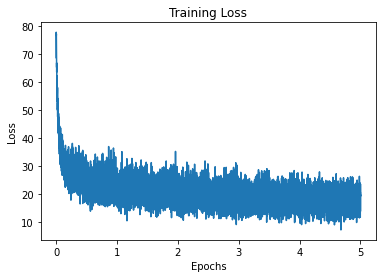

In [12]:
x_range = np.array(list(range(len(train_losses)))) / (200000/batch_size)
plt.plot(x_range, train_losses)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('train_loss_2.png')
plt.show()

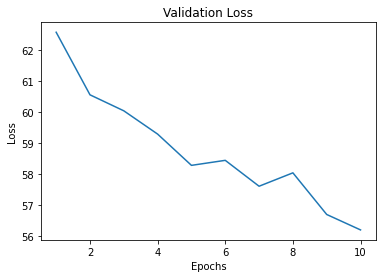

In [13]:
x_range = list(range(1, num_epochs + 1))

plt.plot(x_range, np.array(val_losses))
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('val_loss_2.png')
plt.show()

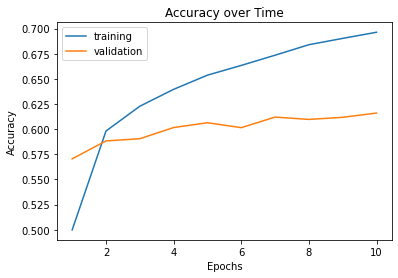

In [16]:
plt.plot(x_range, np.array(train_accuracy), label='training')
plt.plot(x_range, np.array(val_accuracy), label='validation')

plt.title('Accuracy over Time')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

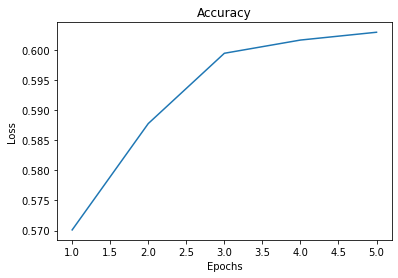

In [83]:
plt.plot(x_range, np.array(val_accuracy))
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.savefig('val_loss.png')
plt.show()